In [2]:
#Import the libraries we will need.
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.contrib.slim as slim
import os
import scipy.misc
import scipy
import sklearn.datasets

In [46]:
BATCH_SIZE=100

In [3]:
images = sklearn.datasets.load_digits().images
m = images.max()
images /= m
reshape = tf.reshape(images, shape=[-1,8,8,1])
with tf.Session() as sess:
    image_reshaped = sess.run(reshape)
    image_labels = sklearn.datasets.load_digits().target
    for i in range(0, len(image_labels)):
        if image_labels[i] == 0:
            image_labels[i] = 1
        else:
            image_labels[i] = 0
    image_labels = np.reshape(image_labels, [1797, 1])
            

In [4]:
def discriminator_decoder(input_batch):
    pool_1 = tf.layers.average_pooling2d(inputs=input_batch, pool_size=[4, 4], strides=4)
    pool1_flat = tf.reshape(pool_1, [-1, 2 * 2 * 1])
    return pool1_flat


In [51]:
def discriminator_image(input_batch, reuse=True, trainable=True):
    conv1 = tf.layers.conv2d(
      inputs=input_batch,
      filters=32,
      kernel_size=[5, 5],
      activation=tf.nn.relu,
      name="conv1_disc",
      trainable=trainable,
      reuse=reuse)

    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    pool2_flat = tf.reshape(pool1, [-1, 1 * 2 * 64])


    logits = tf.layers.dense(inputs=pool2_flat, units=1, activation=tf.tanh, trainable=trainable, name="dense1_disc",
      reuse=reuse)
    return logits

input_layer = tf.placeholder(tf.float32, shape=(None, 8, 8, 1))
logits = discriminator_image(input_layer)

labels = tf.placeholder(tf.float32, shape=(None, 1))
loss_recognized_image = tf.reduce_mean(tf.abs(logits - labels))

des_2_trainer = tf.train.GradientDescentOptimizer(0.1).minimize(loss_recognized_image)

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    for i in range(0, len(image_reshaped)):
        sess.run(des_2_trainer, feed_dict={input_layer: [image_reshaped[i]], labels: [image_labels[i]]})
#     print(sess.run(discriminator_image(tf.convert_to_tensor([image_reshaped[0]]))))
        
    

In [71]:
def image_generator(noise, message, reuse=True):
    input_layer = tf.reshape(tf.concat([tf.cast(noise, tf.float32), tf.cast(message, tf.float32)],1), shape=[-1, 8,1])
    conv1 = tf.layers.conv1d(
      inputs=input_layer,
      filters=32,
      kernel_size=[4],
      padding="same",
      name="conv1_gen",
      reuse=True,
      activation=tf.nn.relu)

    pool1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2)
    pool1_flat = tf.reshape(pool1, [-1, 128])

    logits = tf.reshape(tf.layers.dense(inputs=pool1_flat, units=64, activation=tf.sigmoid, name="dense1_gen",
      reuse=reuse), shape=[-1, 8,8,1])
#     output_image = tf.round(logits)
    discriminator_dec = discriminator_decoder(logits)
    return logits, discriminator_dec
    
    
noise = tf.placeholder("float", [None, 4])
message = tf.placeholder("float", [None, 4])
image , discriminator_dec = image_generator(noise, message)
loss_encoded_message = tf.reduce_mean(tf.abs(message - discriminator_dec)) 

input_layer = tf.placeholder(tf.float32, shape=(None, 8, 8, 1))
logits = discriminator_image(input_layer)
labels = tf.placeholder(tf.float32, shape=(None, 1))
loss_recognized_image = tf.reduce_mean(tf.abs(logits - labels))

is_real = discriminator_image(image, True, False)

des_2_trainer = tf.train.GradientDescentOptimizer(0.1).minimize(loss_recognized_image)
optymizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss_encoded_message + (1-is_real))

with tf.Session() as sess:
    messages = [[0,0,0,0], 
                [0,0,0,1], [0,0,1,0], [0,1,0,0], [1,0,0,0],
                [0,0,1,1], [0,1,1,0], [1,1,0,0], [1,0,1,0], [0,1,0,1], [1,0,0,1],
                [0,1,1,1], [1,0,1,1], [1,1,0,1], [1,1,1,0],
                [1,1,1,1]
               ]
    init = tf.global_variables_initializer()
    sess.run(init)
    
    for i in range(0, len(image_reshaped)):
        sess.run(des_2_trainer, feed_dict={input_layer: [image_reshaped[i]], labels: [image_labels[i]]})
        
    for i in range(0, 10000):
        print(sess.run([is_real, optymizer, loss_encoded_message], feed_dict={noise: np.random.uniform(0,1,[16, 4]), message: messages}))
    
    generated_images, generated_codes = sess.run(image_generator(np.random.uniform(-1,1,[16, 4]), messages))


[array([[ 0.0946497],
       [ 0.0946497],
       [ 0.0946497],
       [ 0.0946497],
       [ 0.0946497],
       [ 0.0946497],
       [ 0.0946497],
       [ 0.0946497],
       [ 0.0946497],
       [ 0.0946497],
       [ 0.0946497],
       [ 0.0946497],
       [ 0.0946497],
       [ 0.0946497],
       [ 0.0946497],
       [ 0.0946497]], dtype=float32), None, 0.4994092]
[array([[ 0.93293941],
       [ 0.93293941],
       [ 0.93293941],
       [ 0.93293941],
       [ 0.93293941],
       [ 0.93293941],
       [ 0.93293941],
       [ 0.93293941],
       [ 0.93293941],
       [ 0.93293941],
       [ 0.93293941],
       [ 0.93293941],
       [ 0.93293941],
       [ 0.93293941],
       [ 0.93293941],
       [ 0.93293941]], dtype=float32), None, 0.49910897]
[array([[ 0.95519805],
       [ 0.95519805],
       [ 0.95519805],
       [ 0.95519805],
       [ 0.95519805],
       [ 0.95519805],
       [ 0.95519805],
       [ 0.95519805],
       [ 0.95519805],
       [ 0.95519805],
       [ 0.95519805]

[array([[ 0.99750042],
       [ 0.99750042],
       [ 0.99750042],
       [ 0.99750042],
       [ 0.99750042],
       [ 0.99750042],
       [ 0.99750042],
       [ 0.99750042],
       [ 0.99750042],
       [ 0.99750042],
       [ 0.99750042],
       [ 0.99750042],
       [ 0.99750042],
       [ 0.99750042],
       [ 0.99750042],
       [ 0.99750042]], dtype=float32), None, 0.48091459]
[array([[ 0.99754006],
       [ 0.99754006],
       [ 0.99754006],
       [ 0.99754006],
       [ 0.99754006],
       [ 0.99754006],
       [ 0.99754006],
       [ 0.99754006],
       [ 0.99754006],
       [ 0.99754006],
       [ 0.99754006],
       [ 0.99754006],
       [ 0.99754006],
       [ 0.99754006],
       [ 0.99754006],
       [ 0.99754006]], dtype=float32), None, 0.48014683]
[array([[ 0.99757832],
       [ 0.99757832],
       [ 0.99757832],
       [ 0.99757832],
       [ 0.99757832],
       [ 0.99757832],
       [ 0.99757832],
       [ 0.99757832],
       [ 0.99757832],
       [ 0.99757832],
   

[array([[ 0.99880505],
       [ 0.99880505],
       [ 0.99880505],
       [ 0.99880505],
       [ 0.99880505],
       [ 0.99880505],
       [ 0.99880505],
       [ 0.99880505],
       [ 0.99880505],
       [ 0.99880505],
       [ 0.99880505],
       [ 0.99880505],
       [ 0.99880505],
       [ 0.99880505],
       [ 0.99880505],
       [ 0.99880505]], dtype=float32), None, 0.40751046]
[array([[ 0.99881423],
       [ 0.99881423],
       [ 0.99881423],
       [ 0.99881423],
       [ 0.99881423],
       [ 0.99881423],
       [ 0.99881423],
       [ 0.99881423],
       [ 0.99881423],
       [ 0.99881423],
       [ 0.99881423],
       [ 0.99881423],
       [ 0.99881423],
       [ 0.99881423],
       [ 0.99881423],
       [ 0.99881423]], dtype=float32), None, 0.40464738]
[array([[ 0.99882311],
       [ 0.99882311],
       [ 0.99882311],
       [ 0.99882311],
       [ 0.99882311],
       [ 0.99882311],
       [ 0.99882311],
       [ 0.99882311],
       [ 0.99882311],
       [ 0.99882311],
   

[array([[ 0.99921477],
       [ 0.99915659],
       [ 0.99921477],
       [ 0.99921477],
       [ 0.99921435],
       [ 0.99921477],
       [ 0.99921477],
       [ 0.99921477],
       [ 0.99921477],
       [ 0.99921477],
       [ 0.99919903],
       [ 0.99921477],
       [ 0.99921477],
       [ 0.99921477],
       [ 0.99921477],
       [ 0.99921477]], dtype=float32), None, 0.24912524]
[array([[ 0.9992187 ],
       [ 0.99919719],
       [ 0.9992187 ],
       [ 0.9992187 ],
       [ 0.9992187 ],
       [ 0.9992187 ],
       [ 0.9992187 ],
       [ 0.9992187 ],
       [ 0.9992187 ],
       [ 0.9992187 ],
       [ 0.99914074],
       [ 0.9992187 ],
       [ 0.9992187 ],
       [ 0.9992187 ],
       [ 0.9992187 ],
       [ 0.9992187 ]], dtype=float32), None, 0.26731449]
[array([[ 0.99922258],
       [ 0.99915195],
       [ 0.99922258],
       [ 0.99922258],
       [ 0.99922258],
       [ 0.99922258],
       [ 0.99922258],
       [ 0.99922258],
       [ 0.99922258],
       [ 0.99922258],
   

[array([[ 0.99941701],
       [ 0.99932009],
       [ 0.99941701],
       [ 0.99941701],
       [ 0.99941427],
       [ 0.99941748],
       [ 0.9993006 ],
       [ 0.99941629],
       [ 0.99941701],
       [ 0.99941701],
       [ 0.99930662],
       [ 0.99941701],
       [ 0.99941701],
       [ 0.99941701],
       [ 0.99941701],
       [ 0.99941701]], dtype=float32), None, 0.15015776]
[array([[ 0.99941933],
       [ 0.99933279],
       [ 0.99941933],
       [ 0.9994154 ],
       [ 0.99941665],
       [ 0.99941969],
       [ 0.99941933],
       [ 0.99941957],
       [ 0.99941933],
       [ 0.99941927],
       [ 0.99929667],
       [ 0.99934864],
       [ 0.99941933],
       [ 0.9994176 ],
       [ 0.99941933],
       [ 0.99941933]], dtype=float32), None, 0.15810899]
[array([[ 0.99942142],
       [ 0.99930131],
       [ 0.99942142],
       [ 0.99942142],
       [ 0.99941909],
       [ 0.99942136],
       [ 0.99934912],
       [ 0.9994204 ],
       [ 0.99942142],
       [ 0.99938887],
   

[array([[ 0.99954158],
       [ 0.99946141],
       [ 0.99953443],
       [ 0.99954158],
       [ 0.99953896],
       [ 0.9995417 ],
       [ 0.99950689],
       [ 0.99953985],
       [ 0.99953145],
       [ 0.99950916],
       [ 0.99946743],
       [ 0.99934822],
       [ 0.99954158],
       [ 0.99949521],
       [ 0.99953729],
       [ 0.99954158]], dtype=float32), None, 0.10033112]
[array([[ 0.99954313],
       [ 0.9994483 ],
       [ 0.99952203],
       [ 0.99949813],
       [ 0.99954331],
       [ 0.99954087],
       [ 0.99952841],
       [ 0.99954271],
       [ 0.99954313],
       [ 0.99950939],
       [ 0.99946511],
       [ 0.9994415 ],
       [ 0.99954313],
       [ 0.99949974],
       [ 0.99953669],
       [ 0.99954313]], dtype=float32), None, 0.097995609]
[array([[ 0.99954444],
       [ 0.99945652],
       [ 0.99951994],
       [ 0.99954444],
       [ 0.99956149],
       [ 0.99954492],
       [ 0.99946207],
       [ 0.99954236],
       [ 0.99954122],
       [ 0.99948174],
  

[array([[ 0.99962944],
       [ 0.99958426],
       [ 0.99960065],
       [ 0.99962944],
       [ 0.99962723],
       [ 0.99962896],
       [ 0.99963766],
       [ 0.99962884],
       [ 0.99965495],
       [ 0.99959248],
       [ 0.99959797],
       [ 0.99955946],
       [ 0.99962944],
       [ 0.99959713],
       [ 0.99962294],
       [ 0.99962944]], dtype=float32), None, 0.072538003]
[array([[ 0.99963039],
       [ 0.99959195],
       [ 0.99960637],
       [ 0.99957371],
       [ 0.99963176],
       [ 0.99963063],
       [ 0.99959213],
       [ 0.99962902],
       [ 0.99960691],
       [ 0.99963039],
       [ 0.99959832],
       [ 0.99963039],
       [ 0.99963039],
       [ 0.99960208],
       [ 0.99962658],
       [ 0.99963039]], dtype=float32), None, 0.069909222]
[array([[ 0.99963135],
       [ 0.99958569],
       [ 0.99960506],
       [ 0.99955124],
       [ 0.9996441 ],
       [ 0.9996314 ],
       [ 0.99962831],
       [ 0.99963027],
       [ 0.9996599 ],
       [ 0.99960613],
 

[array([[ 0.99969131],
       [ 0.99967825],
       [ 0.9996708 ],
       [ 0.9996264 ],
       [ 0.99969906],
       [ 0.99969119],
       [ 0.99966425],
       [ 0.99969053],
       [ 0.9997406 ],
       [ 0.99967432],
       [ 0.99968588],
       [ 0.99959308],
       [ 0.99969131],
       [ 0.99968106],
       [ 0.9996835 ],
       [ 0.99969131]], dtype=float32), None, 0.03584186]
[array([[ 0.99969196],
       [ 0.99967825],
       [ 0.99966884],
       [ 0.99969196],
       [ 0.99970287],
       [ 0.99969131],
       [ 0.99970865],
       [ 0.99969113],
       [ 0.99971795],
       [ 0.99963135],
       [ 0.99968696],
       [ 0.99959213],
       [ 0.99969196],
       [ 0.99968171],
       [ 0.999686  ],
       [ 0.99969196]], dtype=float32), None, 0.047417343]
[array([[ 0.99969244],
       [ 0.99967712],
       [ 0.99967712],
       [ 0.99969256],
       [ 0.99971837],
       [ 0.99969167],
       [ 0.99966735],
       [ 0.99969178],
       [ 0.99971026],
       [ 0.9996832 ],
  

[array([[ 0.99974179],
       [ 0.99974865],
       [ 0.99972624],
       [ 0.99974179],
       [ 0.9997614 ],
       [ 0.99974149],
       [ 0.99973398],
       [ 0.99974179],
       [ 0.99978125],
       [ 0.99967903],
       [ 0.99975419],
       [ 0.99969053],
       [ 0.99974179],
       [ 0.999749  ],
       [ 0.99973452],
       [ 0.99974179]], dtype=float32), None, 0.028804965]
[array([[ 0.99974227],
       [ 0.99975264],
       [ 0.99972731],
       [ 0.99971002],
       [ 0.99976289],
       [ 0.99974233],
       [ 0.99973387],
       [ 0.99974245],
       [ 0.99979216],
       [ 0.99971259],
       [ 0.99975461],
       [ 0.99969119],
       [ 0.99974227],
       [ 0.99974924],
       [ 0.99973494],
       [ 0.99974227]], dtype=float32), None, 0.023665778]
[array([[ 0.99974269],
       [ 0.99974996],
       [ 0.99973309],
       [ 0.99970472],
       [ 0.99977136],
       [ 0.99974245],
       [ 0.99975431],
       [ 0.99974287],
       [ 0.99973291],
       [ 0.99969316],
 

[array([[ 0.99978203],
       [ 0.99980223],
       [ 0.99977195],
       [ 0.99975169],
       [ 0.99980813],
       [ 0.99978173],
       [ 0.99978912],
       [ 0.9997822 ],
       [ 0.999789  ],
       [ 0.999749  ],
       [ 0.99980497],
       [ 0.99974221],
       [ 0.99978191],
       [ 0.99980026],
       [ 0.99977565],
       [ 0.99978191]], dtype=float32), None, 0.016723912]
[array([[ 0.99978232],
       [ 0.99980402],
       [ 0.99977136],
       [ 0.99976736],
       [ 0.9998073 ],
       [ 0.99978203],
       [ 0.99978691],
       [ 0.9997825 ],
       [ 0.99980015],
       [ 0.9997499 ],
       [ 0.99980491],
       [ 0.9997443 ],
       [ 0.99978232],
       [ 0.9998005 ],
       [ 0.99977571],
       [ 0.99978232]], dtype=float32), None, 0.015699748]
[array([[ 0.99978262],
       [ 0.99980611],
       [ 0.99977148],
       [ 0.99975467],
       [ 0.99980843],
       [ 0.99978232],
       [ 0.99979997],
       [ 0.99978274],
       [ 0.99983102],
       [ 0.99975175],
 

[array([[ 0.9998095 ],
       [ 0.9998368 ],
       [ 0.99980336],
       [ 0.99979967],
       [ 0.99983662],
       [ 0.99980927],
       [ 0.99982095],
       [ 0.99980974],
       [ 0.99983531],
       [ 0.99980909],
       [ 0.99983776],
       [ 0.99978876],
       [ 0.9998095 ],
       [ 0.99983358],
       [ 0.99980384],
       [ 0.9998095 ]], dtype=float32), None, 0.01784211]
[array([[ 0.99980962],
       [ 0.9998371 ],
       [ 0.99980354],
       [ 0.99979281],
       [ 0.99983245],
       [ 0.9998095 ],
       [ 0.99982142],
       [ 0.99980992],
       [ 0.99984926],
       [ 0.99980336],
       [ 0.99983764],
       [ 0.99978721],
       [ 0.99980986],
       [ 0.999834  ],
       [ 0.99980384],
       [ 0.99980986]], dtype=float32), None, 0.0088579953]
[array([[ 0.9998101 ],
       [ 0.99983728],
       [ 0.99980325],
       [ 0.99979192],
       [ 0.99983495],
       [ 0.9998098 ],
       [ 0.9998222 ],
       [ 0.99981016],
       [ 0.9998557 ],
       [ 0.99980605],
 

[array([[ 0.99982393],
       [ 0.99985397],
       [ 0.99981999],
       [ 0.99981683],
       [ 0.99985236],
       [ 0.99982387],
       [ 0.99983889],
       [ 0.99982405],
       [ 0.99986404],
       [ 0.99982834],
       [ 0.99985409],
       [ 0.999807  ],
       [ 0.9998275 ],
       [ 0.99985063],
       [ 0.9998185 ],
       [ 0.99982393]], dtype=float32), None, 0.0077368431]
[array([[ 0.99982423],
       [ 0.99985456],
       [ 0.99982119],
       [ 0.99981141],
       [ 0.99984998],
       [ 0.99982399],
       [ 0.99983972],
       [ 0.99982423],
       [ 0.99984384],
       [ 0.99983114],
       [ 0.99985445],
       [ 0.99981534],
       [ 0.9998275 ],
       [ 0.99985111],
       [ 0.99981904],
       [ 0.99982423]], dtype=float32), None, 0.014998823]
[array([[ 0.99982435],
       [ 0.99985445],
       [ 0.99982107],
       [ 0.99981403],
       [ 0.99985254],
       [ 0.99982411],
       [ 0.99983925],
       [ 0.99982452],
       [ 0.99986863],
       [ 0.99983025],


[array([[ 0.99983692],
       [ 0.99986905],
       [ 0.99983418],
       [ 0.99983352],
       [ 0.99986047],
       [ 0.99983656],
       [ 0.99985403],
       [ 0.99983692],
       [ 0.99987626],
       [ 0.99985147],
       [ 0.99986851],
       [ 0.99982959],
       [ 0.9998368 ],
       [ 0.99986553],
       [ 0.99983251],
       [ 0.9998368 ]], dtype=float32), None, 0.012263346]
[array([[ 0.99983704],
       [ 0.99986905],
       [ 0.99983639],
       [ 0.99983603],
       [ 0.99986488],
       [ 0.9998368 ],
       [ 0.99985427],
       [ 0.9998371 ],
       [ 0.99988192],
       [ 0.99985099],
       [ 0.99986899],
       [ 0.99982673],
       [ 0.99983925],
       [ 0.99986559],
       [ 0.99983293],
       [ 0.99983692]], dtype=float32), None, 0.0096126143]
[array([[ 0.99983698],
       [ 0.99986929],
       [ 0.99983633],
       [ 0.9998287 ],
       [ 0.9998638 ],
       [ 0.99983692],
       [ 0.99985433],
       [ 0.99983716],
       [ 0.99988031],
       [ 0.99984998],


[array([[ 0.99985075],
       [ 0.99988687],
       [ 0.99984998],
       [ 0.99984854],
       [ 0.99987966],
       [ 0.99985045],
       [ 0.99987018],
       [ 0.99985075],
       [ 0.99989235],
       [ 0.99987298],
       [ 0.99988389],
       [ 0.99984735],
       [ 0.99986184],
       [ 0.99988127],
       [ 0.99984717],
       [ 0.99985051]], dtype=float32), None, 0.0073701064]
[array([[ 0.99985075],
       [ 0.99988461],
       [ 0.99985337],
       [ 0.99984884],
       [ 0.99987918],
       [ 0.99985069],
       [ 0.99987048],
       [ 0.99985081],
       [ 0.99988735],
       [ 0.99987233],
       [ 0.99988401],
       [ 0.99984652],
       [ 0.99986196],
       [ 0.99988145],
       [ 0.99984741],
       [ 0.99985075]], dtype=float32), None, 0.0078583276]
[array([[ 0.99985093],
       [ 0.9998849 ],
       [ 0.99985296],
       [ 0.99984872],
       [ 0.99987853],
       [ 0.99985063],
       [ 0.99986935],
       [ 0.99985111],
       [ 0.99988818],
       [ 0.99987328],

[array([[ 0.99985909],
       [ 0.99989384],
       [ 0.99986279],
       [ 0.9998582 ],
       [ 0.99988788],
       [ 0.99985892],
       [ 0.99987978],
       [ 0.99985909],
       [ 0.99990135],
       [ 0.99988592],
       [ 0.99989295],
       [ 0.99985784],
       [ 0.99987137],
       [ 0.99989051],
       [ 0.99985629],
       [ 0.99985898]], dtype=float32), None, 0.0034460872]
[array([[ 0.99985909],
       [ 0.99989402],
       [ 0.99986213],
       [ 0.99985856],
       [ 0.99988955],
       [ 0.99985904],
       [ 0.99987984],
       [ 0.99985927],
       [ 0.99988621],
       [ 0.99988616],
       [ 0.99989283],
       [ 0.99985802],
       [ 0.999874  ],
       [ 0.99989074],
       [ 0.99985629],
       [ 0.99985921]], dtype=float32), None, 0.0069745379]
[array([[ 0.99985939],
       [ 0.99989408],
       [ 0.99986303],
       [ 0.99985838],
       [ 0.99988884],
       [ 0.99985909],
       [ 0.99988002],
       [ 0.99985933],
       [ 0.99989939],
       [ 0.99988526],

[array([[ 0.99986935],
       [ 0.99990451],
       [ 0.99987018],
       [ 0.99987137],
       [ 0.99989879],
       [ 0.99986917],
       [ 0.99989152],
       [ 0.99986935],
       [ 0.99990356],
       [ 0.99990058],
       [ 0.99990362],
       [ 0.99987203],
       [ 0.99988252],
       [ 0.99990159],
       [ 0.99986708],
       [ 0.99986935]], dtype=float32), None, 0.0055103581]
[array([[ 0.99986935],
       [ 0.99990463],
       [ 0.99987233],
       [ 0.99987155],
       [ 0.99989885],
       [ 0.99986917],
       [ 0.9998914 ],
       [ 0.99986953],
       [ 0.99990433],
       [ 0.99990106],
       [ 0.99990356],
       [ 0.99987191],
       [ 0.99988353],
       [ 0.99990153],
       [ 0.99986708],
       [ 0.99986935]], dtype=float32), None, 0.0077720731]
[array([[ 0.99986959],
       [ 0.99990481],
       [ 0.99987429],
       [ 0.99987149],
       [ 0.999897  ],
       [ 0.99986935],
       [ 0.99989152],
       [ 0.99986964],
       [ 0.99990565],
       [ 0.99990094],

[array([[ 0.99987549],
       [ 0.99991095],
       [ 0.99988192],
       [ 0.99987936],
       [ 0.99990362],
       [ 0.99987531],
       [ 0.99989617],
       [ 0.99987549],
       [ 0.9999162 ],
       [ 0.99990845],
       [ 0.99990994],
       [ 0.99988049],
       [ 0.99989378],
       [ 0.99990821],
       [ 0.99987394],
       [ 0.99987549]], dtype=float32), None, 0.0066209622]
[array([[ 0.99987561],
       [ 0.99991083],
       [ 0.99987763],
       [ 0.99987948],
       [ 0.99990475],
       [ 0.99987543],
       [ 0.99989849],
       [ 0.99987572],
       [ 0.99991608],
       [ 0.9999088 ],
       [ 0.99991   ],
       [ 0.99988061],
       [ 0.99989456],
       [ 0.99990821],
       [ 0.9998737 ],
       [ 0.99987561]], dtype=float32), None, 0.0046476168]
[array([[ 0.99987561],
       [ 0.99991119],
       [ 0.99988228],
       [ 0.99987966],
       [ 0.99990547],
       [ 0.99987537],
       [ 0.99989736],
       [ 0.99987566],
       [ 0.9999162 ],
       [ 0.9999094 ],

[array([[ 0.99988079],
       [ 0.99991637],
       [ 0.99988806],
       [ 0.99988562],
       [ 0.99990898],
       [ 0.99988079],
       [ 0.99990433],
       [ 0.99988097],
       [ 0.99991894],
       [ 0.99991632],
       [ 0.99991548],
       [ 0.99988765],
       [ 0.99990106],
       [ 0.99991381],
       [ 0.9998796 ],
       [ 0.99988079]], dtype=float32), None, 0.0058229091]
[array([[ 0.99988085],
       [ 0.99991691],
       [ 0.99988878],
       [ 0.99988616],
       [ 0.99991041],
       [ 0.99988079],
       [ 0.99990445],
       [ 0.99988109],
       [ 0.99992043],
       [ 0.99991643],
       [ 0.99991554],
       [ 0.99988639],
       [ 0.99989915],
       [ 0.99991381],
       [ 0.99987954],
       [ 0.99988085]], dtype=float32), None, 0.0048882253]
[array([[ 0.99988097],
       [ 0.99991679],
       [ 0.99988806],
       [ 0.99988639],
       [ 0.99991053],
       [ 0.99988079],
       [ 0.99990445],
       [ 0.99988109],
       [ 0.99992031],
       [ 0.99991655],

[array([[ 0.99988604],
       [ 0.99992168],
       [ 0.99989486],
       [ 0.99989265],
       [ 0.99991536],
       [ 0.9998858 ],
       [ 0.99990892],
       [ 0.99988621],
       [ 0.99992281],
       [ 0.99992359],
       [ 0.99992085],
       [ 0.99989432],
       [ 0.99990761],
       [ 0.99991918],
       [ 0.99988508],
       [ 0.99988604]], dtype=float32), None, 0.0038237527]
[array([[ 0.99988616],
       [ 0.99992162],
       [ 0.99989432],
       [ 0.99989283],
       [ 0.99991477],
       [ 0.99988592],
       [ 0.99991006],
       [ 0.9998861 ],
       [ 0.99992567],
       [ 0.99992377],
       [ 0.99992085],
       [ 0.99989474],
       [ 0.99990737],
       [ 0.99991906],
       [ 0.9998852 ],
       [ 0.99988616]], dtype=float32), None, 0.0019839597]
[array([[ 0.99988621],
       [ 0.9999218 ],
       [ 0.9998945 ],
       [ 0.99989295],
       [ 0.99991578],
       [ 0.99988604],
       [ 0.99990976],
       [ 0.99988621],
       [ 0.99992561],
       [ 0.99992293],

[array([[ 0.99989074],
       [ 0.99992633],
       [ 0.99989867],
       [ 0.99989861],
       [ 0.99991941],
       [ 0.99989063],
       [ 0.99991512],
       [ 0.99989069],
       [ 0.99991918],
       [ 0.99992913],
       [ 0.99992526],
       [ 0.99990046],
       [ 0.9999122 ],
       [ 0.99992383],
       [ 0.99989003],
       [ 0.99989074]], dtype=float32), None, 0.0053547993]
[array([[ 0.99989069],
       [ 0.99992621],
       [ 0.99989951],
       [ 0.99989843],
       [ 0.99991989],
       [ 0.99989051],
       [ 0.99991459],
       [ 0.99989098],
       [ 0.99992931],
       [ 0.99992961],
       [ 0.99992537],
       [ 0.9999007 ],
       [ 0.99991184],
       [ 0.999924  ],
       [ 0.99988991],
       [ 0.99989069]], dtype=float32), None, 0.0042203101]
[array([[ 0.9998908 ],
       [ 0.99992645],
       [ 0.9999001 ],
       [ 0.99989873],
       [ 0.99991959],
       [ 0.99989063],
       [ 0.99991512],
       [ 0.99989092],
       [ 0.99992889],
       [ 0.99992907],

[array([[ 0.9998948 ],
       [ 0.99993008],
       [ 0.99990302],
       [ 0.99990344],
       [ 0.99992365],
       [ 0.99989462],
       [ 0.99991953],
       [ 0.9998948 ],
       [ 0.9999314 ],
       [ 0.99993438],
       [ 0.99992925],
       [ 0.99990582],
       [ 0.99991685],
       [ 0.99992794],
       [ 0.9998942 ],
       [ 0.9998948 ]], dtype=float32), None, 0.003002329]
[array([[ 0.99989492],
       [ 0.99993032],
       [ 0.99990463],
       [ 0.99990368],
       [ 0.99992234],
       [ 0.99989474],
       [ 0.9999193 ],
       [ 0.99989492],
       [ 0.99993265],
       [ 0.99993306],
       [ 0.99992931],
       [ 0.99990582],
       [ 0.99991721],
       [ 0.99992806],
       [ 0.99989438],
       [ 0.99989492]], dtype=float32), None, 0.0046277093]
[array([[ 0.9998948 ],
       [ 0.99993032],
       [ 0.9999035 ],
       [ 0.9999038 ],
       [ 0.99992388],
       [ 0.9998948 ],
       [ 0.99991947],
       [ 0.99989498],
       [ 0.99993098],
       [ 0.99993467],


[array([[ 0.99990112],
       [ 0.99993622],
       [ 0.99991173],
       [ 0.99991119],
       [ 0.99992967],
       [ 0.99990088],
       [ 0.99992621],
       [ 0.99990106],
       [ 0.99993825],
       [ 0.99994159],
       [ 0.99993545],
       [ 0.99991298],
       [ 0.99992478],
       [ 0.99993414],
       [ 0.99990118],
       [ 0.99990112]], dtype=float32), None, 0.0022866721]
[array([[ 0.99990118],
       [ 0.99993616],
       [ 0.99991155],
       [ 0.99991131],
       [ 0.9999302 ],
       [ 0.999901  ],
       [ 0.99992621],
       [ 0.99990106],
       [ 0.99993765],
       [ 0.99994147],
       [ 0.99993527],
       [ 0.99991405],
       [ 0.9999243 ],
       [ 0.99993449],
       [ 0.99990129],
       [ 0.99990118]], dtype=float32), None, 0.0019718083]
[array([[ 0.99990106],
       [ 0.99993634],
       [ 0.99991137],
       [ 0.9999072 ],
       [ 0.9999302 ],
       [ 0.99990106],
       [ 0.99992627],
       [ 0.99990118],
       [ 0.99993795],
       [ 0.99994206],

[array([[ 0.99990433],
       [ 0.99993938],
       [ 0.99991387],
       [ 0.99991512],
       [ 0.99993318],
       [ 0.99990433],
       [ 0.99992895],
       [ 0.99990445],
       [ 0.99994016],
       [ 0.99994534],
       [ 0.99993843],
       [ 0.99991816],
       [ 0.99992782],
       [ 0.99993736],
       [ 0.99990475],
       [ 0.99990433]], dtype=float32), None, 0.0025191084]
[array([[ 0.99990445],
       [ 0.99993956],
       [ 0.99991548],
       [ 0.99991536],
       [ 0.999933  ],
       [ 0.99990422],
       [ 0.99992985],
       [ 0.99990457],
       [ 0.9999401 ],
       [ 0.9999457 ],
       [ 0.99993855],
       [ 0.99991775],
       [ 0.99992794],
       [ 0.99993759],
       [ 0.99990487],
       [ 0.99990445]], dtype=float32), None, 0.0023636613]
[array([[ 0.99990445],
       [ 0.99993926],
       [ 0.99991536],
       [ 0.99991512],
       [ 0.99993229],
       [ 0.99990433],
       [ 0.99992985],
       [ 0.99990451],
       [ 0.99994069],
       [ 0.99994528],

[array([[ 0.99990737],
       [ 0.99994212],
       [ 0.99991834],
       [ 0.99991846],
       [ 0.99993551],
       [ 0.99990702],
       [ 0.99993265],
       [ 0.99990737],
       [ 0.99994302],
       [ 0.99994904],
       [ 0.99994099],
       [ 0.99992132],
       [ 0.99993104],
       [ 0.99994022],
       [ 0.99990785],
       [ 0.99990737]], dtype=float32), None, 0.0018783914]
[array([[ 0.99990737],
       [ 0.99994206],
       [ 0.99991685],
       [ 0.99991834],
       [ 0.99993545],
       [ 0.99990714],
       [ 0.99993283],
       [ 0.99990731],
       [ 0.99993962],
       [ 0.9999491 ],
       [ 0.99994093],
       [ 0.99992162],
       [ 0.99993056],
       [ 0.9999401 ],
       [ 0.99990779],
       [ 0.99990737]], dtype=float32), None, 0.00421446]
[array([[ 0.99990737],
       [ 0.99994206],
       [ 0.99991792],
       [ 0.99991888],
       [ 0.99993593],
       [ 0.99990726],
       [ 0.99993289],
       [ 0.99990743],
       [ 0.99994314],
       [ 0.99994886],
 

[array([[ 0.99991012],
       [ 0.99994451],
       [ 0.9999215 ],
       [ 0.9999221 ],
       [ 0.99993831],
       [ 0.99990994],
       [ 0.99993563],
       [ 0.99991018],
       [ 0.99994361],
       [ 0.99995184],
       [ 0.99994373],
       [ 0.99992496],
       [ 0.99993485],
       [ 0.99994278],
       [ 0.99991083],
       [ 0.99991012]], dtype=float32), None, 0.0024208489]
[array([[ 0.99990994],
       [ 0.99994463],
       [ 0.9999218 ],
       [ 0.99992222],
       [ 0.99993789],
       [ 0.99990994],
       [ 0.99993569],
       [ 0.99991018],
       [ 0.99994498],
       [ 0.99995178],
       [ 0.99994391],
       [ 0.99992496],
       [ 0.99993491],
       [ 0.9999429 ],
       [ 0.99991089],
       [ 0.99990994]], dtype=float32), None, 0.0020074248]
[array([[ 0.99991006],
       [ 0.99994463],
       [ 0.99992138],
       [ 0.9999221 ],
       [ 0.99993843],
       [ 0.99991006],
       [ 0.99993581],
       [ 0.99991018],
       [ 0.99994552],
       [ 0.99995124],

[array([[ 0.9999125 ],
       [ 0.99994683],
       [ 0.99992388],
       [ 0.99992508],
       [ 0.99994081],
       [ 0.99991238],
       [ 0.99993819],
       [ 0.99991256],
       [ 0.99994719],
       [ 0.9999544 ],
       [ 0.99994719],
       [ 0.99992806],
       [ 0.99993742],
       [ 0.99994504],
       [ 0.99991351],
       [ 0.9999125 ]], dtype=float32), None, 0.0019464154]
[array([[ 0.99991262],
       [ 0.99994671],
       [ 0.9999246 ],
       [ 0.99992484],
       [ 0.99994105],
       [ 0.99991238],
       [ 0.99993825],
       [ 0.99991256],
       [ 0.99994355],
       [ 0.99995458],
       [ 0.99994725],
       [ 0.99992806],
       [ 0.99993765],
       [ 0.9999454 ],
       [ 0.99991351],
       [ 0.99991262]], dtype=float32), None, 0.0042571477]
[array([[ 0.99991256],
       [ 0.99994689],
       [ 0.99992406],
       [ 0.99992502],
       [ 0.99994093],
       [ 0.99991244],
       [ 0.99993777],
       [ 0.99991274],
       [ 0.99994636],
       [ 0.99995482],

[array([[ 0.99991518],
       [ 0.9999491 ],
       [ 0.99992716],
       [ 0.99992645],
       [ 0.99994338],
       [ 0.99991482],
       [ 0.99994081],
       [ 0.99991518],
       [ 0.99994922],
       [ 0.99995726],
       [ 0.99995023],
       [ 0.99993098],
       [ 0.99994045],
       [ 0.99994755],
       [ 0.9999162 ],
       [ 0.99991518]], dtype=float32), None, 0.0023318403]
[array([[ 0.99991506],
       [ 0.99994922],
       [ 0.99992698],
       [ 0.99992788],
       [ 0.99994302],
       [ 0.99991506],
       [ 0.99994081],
       [ 0.99991512],
       [ 0.99994826],
       [ 0.99995673],
       [ 0.99994951],
       [ 0.99993068],
       [ 0.99994028],
       [ 0.99994755],
       [ 0.9999162 ],
       [ 0.99991506]], dtype=float32), None, 0.0027334441]
[array([[ 0.99991506],
       [ 0.99994928],
       [ 0.99992704],
       [ 0.99992806],
       [ 0.9999432 ],
       [ 0.99991506],
       [ 0.99994093],
       [ 0.999915  ],
       [ 0.99994934],
       [ 0.99995738],

[array([[ 0.99991721],
       [ 0.999951  ],
       [ 0.99992973],
       [ 0.99993038],
       [ 0.99994516],
       [ 0.99991721],
       [ 0.99994326],
       [ 0.99991727],
       [ 0.99994981],
       [ 0.99995881],
       [ 0.99995297],
       [ 0.99993366],
       [ 0.99994302],
       [ 0.99994969],
       [ 0.99991858],
       [ 0.99991721]], dtype=float32), None, 0.0031449231]
[array([[ 0.99991727],
       [ 0.99995124],
       [ 0.99992913],
       [ 0.99993062],
       [ 0.99994552],
       [ 0.99991715],
       [ 0.99994326],
       [ 0.99991745],
       [ 0.99994951],
       [ 0.99995941],
       [ 0.99995279],
       [ 0.99993372],
       [ 0.99994266],
       [ 0.99994981],
       [ 0.99991864],
       [ 0.99991727]], dtype=float32), None, 0.0023987852]
[array([[ 0.99991727],
       [ 0.9999513 ],
       [ 0.99992901],
       [ 0.9999308 ],
       [ 0.99994534],
       [ 0.99991721],
       [ 0.99994314],
       [ 0.99991745],
       [ 0.9999513 ],
       [ 0.99995959],

[array([[ 0.9999193 ],
       [ 0.99995303],
       [ 0.99993187],
       [ 0.99993306],
       [ 0.99994743],
       [ 0.99991924],
       [ 0.99994504],
       [ 0.99991947],
       [ 0.99995339],
       [ 0.99996126],
       [ 0.999955  ],
       [ 0.99993593],
       [ 0.99994451],
       [ 0.99995178],
       [ 0.99992108],
       [ 0.9999193 ]], dtype=float32), None, 0.0022829743]
[array([[ 0.99991953],
       [ 0.99995297],
       [ 0.99993145],
       [ 0.99993324],
       [ 0.99994707],
       [ 0.99991935],
       [ 0.99994546],
       [ 0.99991947],
       [ 0.9999525 ],
       [ 0.99996185],
       [ 0.9999553 ],
       [ 0.99993598],
       [ 0.9999451 ],
       [ 0.99995172],
       [ 0.99992108],
       [ 0.99991953]], dtype=float32), None, 0.0019820079]
[array([[ 0.99991947],
       [ 0.99995297],
       [ 0.99993181],
       [ 0.99993241],
       [ 0.99994731],
       [ 0.99991953],
       [ 0.99994534],
       [ 0.99991959],
       [ 0.99995226],
       [ 0.99996179],

[array([[ 0.9999215 ],
       [ 0.99995458],
       [ 0.99993408],
       [ 0.99993467],
       [ 0.99994898],
       [ 0.99992138],
       [ 0.99994731],
       [ 0.99992162],
       [ 0.99995458],
       [ 0.99996287],
       [ 0.99995768],
       [ 0.99993831],
       [ 0.99994534],
       [ 0.99995345],
       [ 0.99992275],
       [ 0.9999215 ]], dtype=float32), None, 0.0033361777]
[array([[ 0.99992144],
       [ 0.99995476],
       [ 0.9999336 ],
       [ 0.99993443],
       [ 0.99994934],
       [ 0.99992144],
       [ 0.99994731],
       [ 0.99992144],
       [ 0.999955  ],
       [ 0.99996364],
       [ 0.99995762],
       [ 0.99993843],
       [ 0.99994731],
       [ 0.99995351],
       [ 0.99992305],
       [ 0.99992144]], dtype=float32), None, 0.0019357993]
[array([[ 0.99992162],
       [ 0.9999547 ],
       [ 0.9999342 ],
       [ 0.99993539],
       [ 0.9999494 ],
       [ 0.9999215 ],
       [ 0.99994743],
       [ 0.99992168],
       [ 0.99995488],
       [ 0.99996305],

[array([[ 0.99992335],
       [ 0.99995631],
       [ 0.9999364 ],
       [ 0.99993765],
       [ 0.99995124],
       [ 0.99992335],
       [ 0.99994856],
       [ 0.99992359],
       [ 0.99995619],
       [ 0.99996549],
       [ 0.99995971],
       [ 0.99994075],
       [ 0.9999494 ],
       [ 0.99995536],
       [ 0.99992514],
       [ 0.99992335]], dtype=float32), None, 0.0014502952]
[array([[ 0.99992335],
       [ 0.99995643],
       [ 0.99993628],
       [ 0.99993765],
       [ 0.99995142],
       [ 0.99992335],
       [ 0.99994928],
       [ 0.99992341],
       [ 0.99995673],
       [ 0.99996501],
       [ 0.99995947],
       [ 0.99994069],
       [ 0.99994886],
       [ 0.99995524],
       [ 0.99992532],
       [ 0.99992335]], dtype=float32), None, 0.0014102135]
[array([[ 0.99992341],
       [ 0.99995649],
       [ 0.99993628],
       [ 0.9999373 ],
       [ 0.99995142],
       [ 0.99992347],
       [ 0.99994892],
       [ 0.99992353],
       [ 0.99995416],
       [ 0.99996519],

[array([[ 0.9999252 ],
       [ 0.99995816],
       [ 0.99993777],
       [ 0.9999398 ],
       [ 0.99995285],
       [ 0.99992532],
       [ 0.999951  ],
       [ 0.99992537],
       [ 0.9999575 ],
       [ 0.99996704],
       [ 0.99996167],
       [ 0.99994272],
       [ 0.99995148],
       [ 0.99995697],
       [ 0.99992704],
       [ 0.9999252 ]], dtype=float32), None, 0.0014110035]
[array([[ 0.99992537],
       [ 0.99995798],
       [ 0.99993795],
       [ 0.99993992],
       [ 0.99995261],
       [ 0.99992526],
       [ 0.999951  ],
       [ 0.99992532],
       [ 0.99995816],
       [ 0.99996674],
       [ 0.99996156],
       [ 0.99994278],
       [ 0.9999516 ],
       [ 0.9999572 ],
       [ 0.99992704],
       [ 0.99992537]], dtype=float32), None, 0.0018724421]
[array([[ 0.99992537],
       [ 0.99995804],
       [ 0.99993843],
       [ 0.99993986],
       [ 0.99995279],
       [ 0.99992526],
       [ 0.99995112],
       [ 0.99992549],
       [ 0.99995822],
       [ 0.99996704],

[array([[ 0.99992698],
       [ 0.99995947],
       [ 0.99994016],
       [ 0.99994159],
       [ 0.99995446],
       [ 0.99992687],
       [ 0.99995273],
       [ 0.99992698],
       [ 0.99995929],
       [ 0.99996865],
       [ 0.99996328],
       [ 0.99994463],
       [ 0.99995279],
       [ 0.9999584 ],
       [ 0.99992889],
       [ 0.99992698]], dtype=float32), None, 0.0011667521]
[array([[ 0.99992681],
       [ 0.99995929],
       [ 0.99993956],
       [ 0.99994159],
       [ 0.99995458],
       [ 0.99992698],
       [ 0.99995279],
       [ 0.99992704],
       [ 0.99995929],
       [ 0.99996847],
       [ 0.99996257],
       [ 0.99994439],
       [ 0.99995261],
       [ 0.99995834],
       [ 0.99992901],
       [ 0.99992681]], dtype=float32), None, 0.0018360976]
[array([[ 0.99992698],
       [ 0.99995941],
       [ 0.9999404 ],
       [ 0.99994165],
       [ 0.99995446],
       [ 0.99992687],
       [ 0.99995214],
       [ 0.99992704],
       [ 0.99995935],
       [ 0.99996877],

[array([[ 0.99992859],
       [ 0.99996066],
       [ 0.999942  ],
       [ 0.99994361],
       [ 0.99995601],
       [ 0.99992853],
       [ 0.99995434],
       [ 0.99992859],
       [ 0.99996018],
       [ 0.99997002],
       [ 0.99996483],
       [ 0.99994618],
       [ 0.99995482],
       [ 0.99995977],
       [ 0.99993068],
       [ 0.99992859]], dtype=float32), None, 0.0010555491]
[array([[ 0.99992859],
       [ 0.99996078],
       [ 0.99994177],
       [ 0.9999423 ],
       [ 0.99995559],
       [ 0.99992847],
       [ 0.99995422],
       [ 0.99992871],
       [ 0.9999603 ],
       [ 0.99997002],
       [ 0.99996489],
       [ 0.99994636],
       [ 0.99995482],
       [ 0.99995965],
       [ 0.9999308 ],
       [ 0.99992859]], dtype=float32), None, 0.0019075039]
[array([[ 0.99992859],
       [ 0.9999609 ],
       [ 0.99994165],
       [ 0.99994183],
       [ 0.99995595],
       [ 0.99992859],
       [ 0.99995416],
       [ 0.99992853],
       [ 0.9999606 ],
       [ 0.9999699 ],

[array([[ 0.99992996],
       [ 0.99996197],
       [ 0.99994361],
       [ 0.99994498],
       [ 0.99995536],
       [ 0.99992996],
       [ 0.99995583],
       [ 0.99993002],
       [ 0.99996185],
       [ 0.99997133],
       [ 0.99996632],
       [ 0.99994802],
       [ 0.99995637],
       [ 0.99996102],
       [ 0.99993223],
       [ 0.99992996]], dtype=float32), None, 0.0013073329]
[array([[ 0.99993014],
       [ 0.99996191],
       [ 0.99994349],
       [ 0.99994504],
       [ 0.99995744],
       [ 0.99993008],
       [ 0.99995571],
       [ 0.9999302 ],
       [ 0.9999603 ],
       [ 0.99997133],
       [ 0.99996614],
       [ 0.99994802],
       [ 0.99995637],
       [ 0.99996102],
       [ 0.99993229],
       [ 0.99993014]], dtype=float32), None, 0.0018392039]
[array([[ 0.99993002],
       [ 0.99996203],
       [ 0.99994373],
       [ 0.99994522],
       [ 0.99995697],
       [ 0.99993014],
       [ 0.99995577],
       [ 0.99993002],
       [ 0.99996185],
       [ 0.99997103],

[array([[ 0.99993163],
       [ 0.99996305],
       [ 0.99994522],
       [ 0.99994683],
       [ 0.99995857],
       [ 0.99993151],
       [ 0.99995726],
       [ 0.99993157],
       [ 0.99996287],
       [ 0.99997264],
       [ 0.99996775],
       [ 0.99994981],
       [ 0.99995726],
       [ 0.99996245],
       [ 0.9999339 ],
       [ 0.99993163]], dtype=float32), None, 0.0010347709]
[array([[ 0.99993157],
       [ 0.99996316],
       [ 0.99994475],
       [ 0.99994612],
       [ 0.99995846],
       [ 0.99993163],
       [ 0.9999572 ],
       [ 0.99993169],
       [ 0.99996316],
       [ 0.99997258],
       [ 0.99996781],
       [ 0.99994981],
       [ 0.99995786],
       [ 0.99996239],
       [ 0.9999339 ],
       [ 0.99993157]], dtype=float32), None, 0.0022350347]
[array([[ 0.99993157],
       [ 0.99996334],
       [ 0.99994522],
       [ 0.99994695],
       [ 0.99995852],
       [ 0.99993157],
       [ 0.99995732],
       [ 0.99993175],
       [ 0.99996287],
       [ 0.99997234],

[array([[ 0.999933  ],
       [ 0.99996448],
       [ 0.99994683],
       [ 0.99994862],
       [ 0.99995995],
       [ 0.999933  ],
       [ 0.99995863],
       [ 0.99993312],
       [ 0.99996394],
       [ 0.99997407],
       [ 0.9999693 ],
       [ 0.99995136],
       [ 0.99995911],
       [ 0.9999637 ],
       [ 0.99993569],
       [ 0.999933  ]], dtype=float32), None, 0.00093468203]
[array([[ 0.99993312],
       [ 0.9999643 ],
       [ 0.99994636],
       [ 0.99994767],
       [ 0.99995989],
       [ 0.999933  ],
       [ 0.99995887],
       [ 0.99993312],
       [ 0.99996412],
       [ 0.99997407],
       [ 0.99996948],
       [ 0.9999516 ],
       [ 0.99995953],
       [ 0.9999637 ],
       [ 0.99993551],
       [ 0.99993312]], dtype=float32), None, 0.0016486972]
[array([[ 0.99993312],
       [ 0.99996459],
       [ 0.99994683],
       [ 0.99994862],
       [ 0.99995971],
       [ 0.99993312],
       [ 0.99995887],
       [ 0.99993312],
       [ 0.99996412],
       [ 0.99997395]

[array([[ 0.99993443],
       [ 0.99996549],
       [ 0.99994838],
       [ 0.99995005],
       [ 0.99996126],
       [ 0.99993443],
       [ 0.99995989],
       [ 0.99993443],
       [ 0.99996489],
       [ 0.99997443],
       [ 0.9999705 ],
       [ 0.99995285],
       [ 0.9999606 ],
       [ 0.99996489],
       [ 0.99993718],
       [ 0.99993443]], dtype=float32), None, 0.0023615407]
[array([[ 0.99993443],
       [ 0.99996555],
       [ 0.99994826],
       [ 0.99995017],
       [ 0.99996126],
       [ 0.99993449],
       [ 0.99996006],
       [ 0.99993455],
       [ 0.99996513],
       [ 0.99997514],
       [ 0.99997044],
       [ 0.99995291],
       [ 0.99996066],
       [ 0.99996489],
       [ 0.99993724],
       [ 0.99993443]], dtype=float32), None, 0.0011938664]
[array([[ 0.99993455],
       [ 0.99996549],
       [ 0.99994838],
       [ 0.99995023],
       [ 0.99996078],
       [ 0.99993438],
       [ 0.99996018],
       [ 0.99993449],
       [ 0.99996394],
       [ 0.99997485],

[array([[ 0.99993575],
       [ 0.9999665 ],
       [ 0.9999491 ],
       [ 0.999951  ],
       [ 0.99996233],
       [ 0.99993563],
       [ 0.9999612 ],
       [ 0.99993587],
       [ 0.99996674],
       [ 0.99997574],
       [ 0.99997175],
       [ 0.99995345],
       [ 0.99996179],
       [ 0.99996608],
       [ 0.99993855],
       [ 0.99993575]], dtype=float32), None, 0.0021456454]
[array([[ 0.99993557],
       [ 0.99996638],
       [ 0.99994975],
       [ 0.99995148],
       [ 0.99996215],
       [ 0.99993563],
       [ 0.99996102],
       [ 0.99993575],
       [ 0.99996662],
       [ 0.99997628],
       [ 0.99997163],
       [ 0.99995434],
       [ 0.99996173],
       [ 0.99996585],
       [ 0.99993855],
       [ 0.99993557]], dtype=float32), None, 0.0013166387]
[array([[ 0.99993593],
       [ 0.9999665 ],
       [ 0.99994963],
       [ 0.99995142],
       [ 0.99996239],
       [ 0.99993557],
       [ 0.9999612 ],
       [ 0.99993587],
       [ 0.99996698],
       [ 0.99997622],

[array([[ 0.999937  ],
       [ 0.99996763],
       [ 0.99995089],
       [ 0.99995273],
       [ 0.99996328],
       [ 0.999937  ],
       [ 0.99996251],
       [ 0.99993712],
       [ 0.99996793],
       [ 0.99997681],
       [ 0.99997282],
       [ 0.99995476],
       [ 0.9999631 ],
       [ 0.99996686],
       [ 0.99993992],
       [ 0.999937  ]], dtype=float32), None, 0.001812211]
[array([[ 0.999937  ],
       [ 0.9999674 ],
       [ 0.999951  ],
       [ 0.99995273],
       [ 0.9999634 ],
       [ 0.999937  ],
       [ 0.99996245],
       [ 0.999937  ],
       [ 0.99996859],
       [ 0.99997711],
       [ 0.99997264],
       [ 0.99995565],
       [ 0.9999631 ],
       [ 0.9999671 ],
       [ 0.9999401 ],
       [ 0.999937  ]], dtype=float32), None, 0.00070442946]
[array([[ 0.99993694],
       [ 0.99996746],
       [ 0.999951  ],
       [ 0.99995291],
       [ 0.99996328],
       [ 0.99993688],
       [ 0.99996251],
       [ 0.999937  ],
       [ 0.99996859],
       [ 0.99997699],

[array([[ 0.99993807],
       [ 0.99996841],
       [ 0.99995214],
       [ 0.9999541 ],
       [ 0.99996436],
       [ 0.99993801],
       [ 0.99996358],
       [ 0.99993825],
       [ 0.99996978],
       [ 0.99997789],
       [ 0.9999736 ],
       [ 0.99995667],
       [ 0.99996352],
       [ 0.99996781],
       [ 0.99994129],
       [ 0.99993807]], dtype=float32), None, 0.00096960843]
[array([[ 0.99993807],
       [ 0.99996847],
       [ 0.99995244],
       [ 0.99995351],
       [ 0.9999643 ],
       [ 0.99993801],
       [ 0.99996352],
       [ 0.99993831],
       [ 0.9999696 ],
       [ 0.99997807],
       [ 0.99997365],
       [ 0.99995685],
       [ 0.99996412],
       [ 0.99996787],
       [ 0.99994129],
       [ 0.99993807]], dtype=float32), None, 0.0021607256]
[array([[ 0.99993825],
       [ 0.99996853],
       [ 0.9999522 ],
       [ 0.9999541 ],
       [ 0.99996424],
       [ 0.99993795],
       [ 0.99996358],
       [ 0.99993807],
       [ 0.9999693 ],
       [ 0.99997801]

[array([[ 0.99993914],
       [ 0.9999693 ],
       [ 0.99995339],
       [ 0.99995428],
       [ 0.99996489],
       [ 0.99993914],
       [ 0.99996465],
       [ 0.99993938],
       [ 0.99997115],
       [ 0.99997896],
       [ 0.99997461],
       [ 0.99995792],
       [ 0.99996483],
       [ 0.99996883],
       [ 0.99994272],
       [ 0.99993914]], dtype=float32), None, 0.0013915099]
[array([[ 0.9999392 ],
       [ 0.99996924],
       [ 0.99995333],
       [ 0.99995506],
       [ 0.99996513],
       [ 0.99993932],
       [ 0.99996436],
       [ 0.9999392 ],
       [ 0.99997109],
       [ 0.99997884],
       [ 0.99997461],
       [ 0.9999578 ],
       [ 0.99996495],
       [ 0.99996877],
       [ 0.99994272],
       [ 0.9999392 ]], dtype=float32), None, 0.0012383034]
[array([[ 0.9999392 ],
       [ 0.9999693 ],
       [ 0.99995357],
       [ 0.99995536],
       [ 0.99996513],
       [ 0.99993914],
       [ 0.99996483],
       [ 0.99993938],
       [ 0.99997139],
       [ 0.9999789 ],

[array([[ 0.99994028],
       [ 0.99997014],
       [ 0.99995458],
       [ 0.99995631],
       [ 0.99996603],
       [ 0.99994022],
       [ 0.99996597],
       [ 0.99994034],
       [ 0.99997246],
       [ 0.99997973],
       [ 0.99997538],
       [ 0.99995887],
       [ 0.9999662 ],
       [ 0.9999696 ],
       [ 0.99994379],
       [ 0.99994028]], dtype=float32), None, 0.0010026442]
[array([[ 0.9999404 ],
       [ 0.99997008],
       [ 0.99995476],
       [ 0.99995631],
       [ 0.9999662 ],
       [ 0.99994022],
       [ 0.99996579],
       [ 0.99994034],
       [ 0.99997133],
       [ 0.99997985],
       [ 0.99997562],
       [ 0.99995911],
       [ 0.99996626],
       [ 0.99996978],
       [ 0.99994379],
       [ 0.9999404 ]], dtype=float32), None, 0.0010801128]
[array([[ 0.99994022],
       [ 0.9999702 ],
       [ 0.9999544 ],
       [ 0.99995655],
       [ 0.99996603],
       [ 0.99994028],
       [ 0.99996597],
       [ 0.99994034],
       [ 0.99997258],
       [ 0.99997973],

[array([[ 0.99994135],
       [ 0.99997085],
       [ 0.99995571],
       [ 0.99995738],
       [ 0.99996674],
       [ 0.99994111],
       [ 0.99996656],
       [ 0.99994129],
       [ 0.99997395],
       [ 0.99998051],
       [ 0.99997634],
       [ 0.99996036],
       [ 0.99996698],
       [ 0.9999705 ],
       [ 0.99994504],
       [ 0.99994135]], dtype=float32), None, 0.00095241249]
[array([[ 0.99994129],
       [ 0.99997079],
       [ 0.99995536],
       [ 0.99995744],
       [ 0.99996698],
       [ 0.99994129],
       [ 0.99996668],
       [ 0.99994141],
       [ 0.99997365],
       [ 0.99998039],
       [ 0.9999764 ],
       [ 0.99996018],
       [ 0.99996722],
       [ 0.99997061],
       [ 0.9999451 ],
       [ 0.99994129]], dtype=float32), None, 0.00068727223]
[array([[ 0.99994141],
       [ 0.99997085],
       [ 0.99995559],
       [ 0.9999575 ],
       [ 0.99996686],
       [ 0.99994129],
       [ 0.99996668],
       [ 0.99994147],
       [ 0.99997377],
       [ 0.99998039

[array([[ 0.99994218],
       [ 0.99997169],
       [ 0.99995691],
       [ 0.99995816],
       [ 0.99996775],
       [ 0.99994218],
       [ 0.99996775],
       [ 0.99994224],
       [ 0.99997455],
       [ 0.99998134],
       [ 0.99997735],
       [ 0.99996126],
       [ 0.99996799],
       [ 0.99997139],
       [ 0.99994612],
       [ 0.99994218]], dtype=float32), None, 0.00086292246]
[array([[ 0.9999423 ],
       [ 0.99997163],
       [ 0.99995661],
       [ 0.9999584 ],
       [ 0.99996775],
       [ 0.9999423 ],
       [ 0.99996734],
       [ 0.99994236],
       [ 0.99997467],
       [ 0.99998105],
       [ 0.99997729],
       [ 0.99996138],
       [ 0.99996787],
       [ 0.99997139],
       [ 0.99994618],
       [ 0.9999423 ]], dtype=float32), None, 0.00091238203]
[array([[ 0.99994218],
       [ 0.99997139],
       [ 0.99995667],
       [ 0.99995834],
       [ 0.99996758],
       [ 0.99994212],
       [ 0.99996752],
       [ 0.9999423 ],
       [ 0.99997467],
       [ 0.99998116

[array([[ 0.99994314],
       [ 0.99997234],
       [ 0.99995774],
       [ 0.99995935],
       [ 0.99996799],
       [ 0.99994308],
       [ 0.99996865],
       [ 0.99994308],
       [ 0.99997437],
       [ 0.99998122],
       [ 0.99997801],
       [ 0.99996233],
       [ 0.99996823],
       [ 0.99997199],
       [ 0.99994719],
       [ 0.99994314]], dtype=float32), None, 0.0023382248]
[array([[ 0.99994314],
       [ 0.99997228],
       [ 0.9999578 ],
       [ 0.99995941],
       [ 0.99996835],
       [ 0.99994308],
       [ 0.99996817],
       [ 0.9999432 ],
       [ 0.99997532],
       [ 0.99998188],
       [ 0.99997807],
       [ 0.99996233],
       [ 0.99996889],
       [ 0.99997187],
       [ 0.99994725],
       [ 0.99994314]], dtype=float32), None, 0.00098423334]
[array([[ 0.9999432 ],
       [ 0.99997222],
       [ 0.99995774],
       [ 0.99995953],
       [ 0.99996847],
       [ 0.99994314],
       [ 0.99996841],
       [ 0.9999432 ],
       [ 0.99997574],
       [ 0.99998188]

[array([[ 0.99994397],
       [ 0.99997282],
       [ 0.99995852],
       [ 0.99995977],
       [ 0.99996924],
       [ 0.99994391],
       [ 0.99996936],
       [ 0.99994403],
       [ 0.99997663],
       [ 0.99998254],
       [ 0.99997866],
       [ 0.99996322],
       [ 0.99996954],
       [ 0.99997264],
       [ 0.99994826],
       [ 0.99994397]], dtype=float32), None, 0.000874146]
[array([[ 0.99994403],
       [ 0.99997294],
       [ 0.99995869],
       [ 0.99996012],
       [ 0.9999693 ],
       [ 0.99994409],
       [ 0.99996936],
       [ 0.99994415],
       [ 0.99997646],
       [ 0.99998236],
       [ 0.99997866],
       [ 0.99996293],
       [ 0.99996948],
       [ 0.99997264],
       [ 0.99994814],
       [ 0.99994403]], dtype=float32), None, 0.00083324342]
[array([[ 0.99994409],
       [ 0.99997294],
       [ 0.99995887],
       [ 0.99996054],
       [ 0.99996907],
       [ 0.99994403],
       [ 0.99996912],
       [ 0.99994397],
       [ 0.99997658],
       [ 0.99998254],

[array([[ 0.99994498],
       [ 0.99997348],
       [ 0.99995947],
       [ 0.99996054],
       [ 0.9999699 ],
       [ 0.99994487],
       [ 0.99997008],
       [ 0.99994498],
       [ 0.99997747],
       [ 0.99998289],
       [ 0.99997938],
       [ 0.999964  ],
       [ 0.99997032],
       [ 0.99997342],
       [ 0.99994922],
       [ 0.99994498]], dtype=float32), None, 0.0011724419]
[array([[ 0.99994498],
       [ 0.99997348],
       [ 0.99995875],
       [ 0.99996096],
       [ 0.99996978],
       [ 0.99994481],
       [ 0.99997014],
       [ 0.99994498],
       [ 0.99997735],
       [ 0.99998271],
       [ 0.99997938],
       [ 0.99996394],
       [ 0.99997014],
       [ 0.99997336],
       [ 0.99994904],
       [ 0.99994498]], dtype=float32), None, 0.0012873032]
[array([[ 0.99994481],
       [ 0.9999736 ],
       [ 0.99995953],
       [ 0.99996132],
       [ 0.99996984],
       [ 0.99994493],
       [ 0.99997014],
       [ 0.99994498],
       [ 0.99997735],
       [ 0.99998301],

[array([[ 0.99994582],
       [ 0.99997413],
       [ 0.99996036],
       [ 0.99996179],
       [ 0.99997038],
       [ 0.99994564],
       [ 0.99997103],
       [ 0.99994582],
       [ 0.9999761 ],
       [ 0.99998355],
       [ 0.99998015],
       [ 0.99996454],
       [ 0.99997085],
       [ 0.99997407],
       [ 0.99994999],
       [ 0.99994582]], dtype=float32), None, 0.0027934203]
[array([[ 0.9999457 ],
       [ 0.99997419],
       [ 0.99996048],
       [ 0.99996209],
       [ 0.99997061],
       [ 0.99994564],
       [ 0.99997109],
       [ 0.99994594],
       [ 0.99997759],
       [ 0.99998355],
       [ 0.99997991],
       [ 0.99996489],
       [ 0.99997103],
       [ 0.99997401],
       [ 0.99995017],
       [ 0.9999457 ]], dtype=float32), None, 0.00083281077]
[array([[ 0.99994576],
       [ 0.99997425],
       [ 0.99996036],
       [ 0.99996191],
       [ 0.9999705 ],
       [ 0.9999457 ],
       [ 0.99997115],
       [ 0.99994576],
       [ 0.99997807],
       [ 0.99998367]

[array([[ 0.99994642],
       [ 0.99997467],
       [ 0.99996108],
       [ 0.99996275],
       [ 0.99997109],
       [ 0.99994636],
       [ 0.99997169],
       [ 0.99994659],
       [ 0.9999792 ],
       [ 0.99998403],
       [ 0.99998057],
       [ 0.99996585],
       [ 0.99997157],
       [ 0.99997461],
       [ 0.999951  ],
       [ 0.99994642]], dtype=float32), None, 0.00054731022]
[array([[ 0.99994665],
       [ 0.99997467],
       [ 0.99996126],
       [ 0.99996305],
       [ 0.99997103],
       [ 0.99994636],
       [ 0.99997157],
       [ 0.99994642],
       [ 0.9999792 ],
       [ 0.99998403],
       [ 0.99998057],
       [ 0.99996573],
       [ 0.99997175],
       [ 0.99997461],
       [ 0.999951  ],
       [ 0.99994665]], dtype=float32), None, 0.00064435974]
[array([[ 0.99994665],
       [ 0.99997485],
       [ 0.99996114],
       [ 0.99996281],
       [ 0.99997115],
       [ 0.99994653],
       [ 0.99997157],
       [ 0.99994659],
       [ 0.99997813],
       [ 0.99998409

[array([[ 0.99994731],
       [ 0.99997556],
       [ 0.99996191],
       [ 0.99996281],
       [ 0.99997163],
       [ 0.99994719],
       [ 0.99997234],
       [ 0.99994725],
       [ 0.99997979],
       [ 0.99998462],
       [ 0.99998111],
       [ 0.99996656],
       [ 0.99997228],
       [ 0.9999752 ],
       [ 0.99995196],
       [ 0.99994731]], dtype=float32), None, 0.001938396]
[array([[ 0.99994731],
       [ 0.99997538],
       [ 0.99996215],
       [ 0.9999637 ],
       [ 0.99997175],
       [ 0.99994731],
       [ 0.99997228],
       [ 0.99994731],
       [ 0.99997962],
       [ 0.99998462],
       [ 0.99998134],
       [ 0.99996668],
       [ 0.99997222],
       [ 0.99997538],
       [ 0.99995184],
       [ 0.99994731]], dtype=float32), None, 0.0010171229]
[array([[ 0.99994737],
       [ 0.99997538],
       [ 0.99996191],
       [ 0.99996388],
       [ 0.99997169],
       [ 0.99994737],
       [ 0.9999724 ],
       [ 0.99994731],
       [ 0.99998003],
       [ 0.99998462],


[array([[ 0.99994808],
       [ 0.99997586],
       [ 0.99996281],
       [ 0.99996436],
       [ 0.99997222],
       [ 0.99994791],
       [ 0.99997318],
       [ 0.99994802],
       [ 0.99997938],
       [ 0.99998504],
       [ 0.99998194],
       [ 0.99996722],
       [ 0.99997288],
       [ 0.99997568],
       [ 0.99995279],
       [ 0.99994808]], dtype=float32), None, 0.0011839068]
[array([[ 0.99994802],
       [ 0.9999758 ],
       [ 0.99996281],
       [ 0.99996418],
       [ 0.99997246],
       [ 0.99994802],
       [ 0.99997294],
       [ 0.99994802],
       [ 0.99998057],
       [ 0.9999851 ],
       [ 0.99998188],
       [ 0.9999671 ],
       [ 0.99997288],
       [ 0.99997586],
       [ 0.99995273],
       [ 0.99994802]], dtype=float32), None, 0.00060568587]
[array([[ 0.99994797],
       [ 0.99997586],
       [ 0.99996275],
       [ 0.99996454],
       [ 0.99997246],
       [ 0.99994802],
       [ 0.99997306],
       [ 0.9999482 ],
       [ 0.99997956],
       [ 0.9999851 ]

[array([[ 0.99994874],
       [ 0.9999764 ],
       [ 0.99996346],
       [ 0.99996513],
       [ 0.99997264],
       [ 0.99994874],
       [ 0.99997377],
       [ 0.99994868],
       [ 0.99998105],
       [ 0.99998558],
       [ 0.99998224],
       [ 0.99996787],
       [ 0.99997348],
       [ 0.9999764 ],
       [ 0.99995357],
       [ 0.99994874]], dtype=float32), None, 0.00082860526]
[array([[ 0.99994874],
       [ 0.99997634],
       [ 0.99996358],
       [ 0.99996525],
       [ 0.99997264],
       [ 0.99994874],
       [ 0.99997365],
       [ 0.99994892],
       [ 0.99998105],
       [ 0.99998504],
       [ 0.99998224],
       [ 0.99996787],
       [ 0.99997354],
       [ 0.9999764 ],
       [ 0.99995357],
       [ 0.99994874]], dtype=float32), None, 0.0015161274]
[array([[ 0.99994874],
       [ 0.99997634],
       [ 0.99996334],
       [ 0.99996537],
       [ 0.99997282],
       [ 0.99994868],
       [ 0.99997401],
       [ 0.99994874],
       [ 0.99998093],
       [ 0.9999854 ]

       [ 0.99994934]], dtype=float32), None, 0.00074610213]
[array([[ 0.99994946],
       [ 0.99997681],
       [ 0.99996418],
       [ 0.99996579],
       [ 0.99997354],
       [ 0.99994928],
       [ 0.99997413],
       [ 0.9999494 ],
       [ 0.99998176],
       [ 0.99998593],
       [ 0.99998283],
       [ 0.99996865],
       [ 0.99997401],
       [ 0.99997687],
       [ 0.99995428],
       [ 0.99994946]], dtype=float32), None, 0.00085212372]
[array([[ 0.99994946],
       [ 0.99997687],
       [ 0.99996436],
       [ 0.99996603],
       [ 0.99997324],
       [ 0.99994946],
       [ 0.99997401],
       [ 0.99994957],
       [ 0.99998188],
       [ 0.99998593],
       [ 0.99998283],
       [ 0.99996853],
       [ 0.99997407],
       [ 0.99997681],
       [ 0.99995428],
       [ 0.99994946]], dtype=float32), None, 0.00061610842]
[array([[ 0.99994951],
       [ 0.99997675],
       [ 0.99996418],
       [ 0.99996597],
       [ 0.99997318],
       [ 0.99994928],
       [ 0.99997431],
   

[array([[ 0.99995005],
       [ 0.99997747],
       [ 0.99996495],
       [ 0.9999665 ],
       [ 0.99997383],
       [ 0.99995005],
       [ 0.99997491],
       [ 0.99995023],
       [ 0.99998224],
       [ 0.99998647],
       [ 0.99998325],
       [ 0.99996924],
       [ 0.99997431],
       [ 0.99997735],
       [ 0.99995512],
       [ 0.99995005]], dtype=float32), None, 0.00096306123]
[array([[ 0.99995023],
       [ 0.99997729],
       [ 0.99996483],
       [ 0.99996662],
       [ 0.99997377],
       [ 0.99995005],
       [ 0.99997497],
       [ 0.99995023],
       [ 0.99998224],
       [ 0.99998623],
       [ 0.99998337],
       [ 0.99996924],
       [ 0.99997449],
       [ 0.99997741],
       [ 0.99995518],
       [ 0.99995023]], dtype=float32), None, 0.00086598913]
[array([[ 0.99995017],
       [ 0.99997729],
       [ 0.99996483],
       [ 0.99996668],
       [ 0.99997383],
       [ 0.99995005],
       [ 0.99997514],
       [ 0.99995011],
       [ 0.99998069],
       [ 0.99998617

[array([[ 0.99995077],
       [ 0.99997789],
       [ 0.99996561],
       [ 0.99996734],
       [ 0.99997437],
       [ 0.99995065],
       [ 0.99997568],
       [ 0.99995089],
       [ 0.9999826 ],
       [ 0.99998653],
       [ 0.99998373],
       [ 0.99997002],
       [ 0.99997509],
       [ 0.99997789],
       [ 0.99995595],
       [ 0.99995077]], dtype=float32), None, 0.00095544127]
[array([[ 0.99995083],
       [ 0.99997777],
       [ 0.99996561],
       [ 0.99996734],
       [ 0.99997431],
       [ 0.99995077],
       [ 0.99997556],
       [ 0.99995089],
       [ 0.99998313],
       [ 0.99998695],
       [ 0.99998361],
       [ 0.99997008],
       [ 0.99997514],
       [ 0.99997783],
       [ 0.99995607],
       [ 0.99995083]], dtype=float32), None, 0.00063093624]
[array([[ 0.99995077],
       [ 0.99997789],
       [ 0.99996561],
       [ 0.99996734],
       [ 0.99997455],
       [ 0.99995083],
       [ 0.9999755 ],
       [ 0.99995077],
       [ 0.99998295],
       [ 0.99998695

[array([[ 0.99995136],
       [ 0.99997824],
       [ 0.99996608],
       [ 0.99996692],
       [ 0.99997479],
       [ 0.99995148],
       [ 0.9999761 ],
       [ 0.99995136],
       [ 0.99998355],
       [ 0.9999873 ],
       [ 0.99998403],
       [ 0.99997061],
       [ 0.99997544],
       [ 0.9999783 ],
       [ 0.99995661],
       [ 0.99995136]], dtype=float32), None, 0.0013865982]
[array([[ 0.9999513 ],
       [ 0.99997813],
       [ 0.99996614],
       [ 0.9999671 ],
       [ 0.99997491],
       [ 0.99995136],
       [ 0.99997622],
       [ 0.99995154],
       [ 0.99998355],
       [ 0.99998713],
       [ 0.99998426],
       [ 0.99997067],
       [ 0.99997556],
       [ 0.99997836],
       [ 0.99995655],
       [ 0.9999513 ]], dtype=float32), None, 0.00094182784]
[array([[ 0.99995136],
       [ 0.99997824],
       [ 0.99996644],
       [ 0.99996793],
       [ 0.99997491],
       [ 0.99995142],
       [ 0.99997622],
       [ 0.99995136],
       [ 0.99998367],
       [ 0.99998724]

[array([[ 0.99995202],
       [ 0.99997866],
       [ 0.99996698],
       [ 0.99996871],
       [ 0.9999755 ],
       [ 0.99995202],
       [ 0.99997663],
       [ 0.99995214],
       [ 0.99998385],
       [ 0.99998748],
       [ 0.99998462],
       [ 0.99997109],
       [ 0.99997622],
       [ 0.9999789 ],
       [ 0.99995744],
       [ 0.99995202]], dtype=float32), None, 0.00065641419]
[array([[ 0.99995202],
       [ 0.99997884],
       [ 0.99996674],
       [ 0.99996865],
       [ 0.99997544],
       [ 0.99995202],
       [ 0.99997669],
       [ 0.99995232],
       [ 0.99998426],
       [ 0.99998778],
       [ 0.99998462],
       [ 0.99997121],
       [ 0.99997616],
       [ 0.99997878],
       [ 0.99995738],
       [ 0.99995202]], dtype=float32), None, 0.0004320915]
[array([[ 0.99995214],
       [ 0.9999786 ],
       [ 0.99996698],
       [ 0.99996871],
       [ 0.99997532],
       [ 0.99995202],
       [ 0.99997663],
       [ 0.9999522 ],
       [ 0.99998403],
       [ 0.99998754]

[array([[ 0.99995273],
       [ 0.9999792 ],
       [ 0.99996734],
       [ 0.9999693 ],
       [ 0.99997568],
       [ 0.99995267],
       [ 0.99997711],
       [ 0.99995267],
       [ 0.99998462],
       [ 0.99998802],
       [ 0.9999851 ],
       [ 0.99997169],
       [ 0.99997669],
       [ 0.99997932],
       [ 0.99995804],
       [ 0.99995273]], dtype=float32), None, 0.0005657046]
[array([[ 0.99995279],
       [ 0.99997908],
       [ 0.9999674 ],
       [ 0.99996924],
       [ 0.99997568],
       [ 0.99995261],
       [ 0.99997729],
       [ 0.99995255],
       [ 0.99998391],
       [ 0.99998796],
       [ 0.99998498],
       [ 0.99997175],
       [ 0.99997669],
       [ 0.9999792 ],
       [ 0.9999581 ],
       [ 0.99995279]], dtype=float32), None, 0.0010740239]
[array([[ 0.99995273],
       [ 0.9999792 ],
       [ 0.99996763],
       [ 0.99996907],
       [ 0.99997586],
       [ 0.99995261],
       [ 0.99997681],
       [ 0.99995273],
       [ 0.9999817 ],
       [ 0.99998796],

[array([[ 0.99995327],
       [ 0.99997956],
       [ 0.99996799],
       [ 0.99996948],
       [ 0.99997622],
       [ 0.99995321],
       [ 0.99997771],
       [ 0.99995339],
       [ 0.9999851 ],
       [ 0.99998838],
       [ 0.99998534],
       [ 0.9999724 ],
       [ 0.99997699],
       [ 0.99997967],
       [ 0.99995863],
       [ 0.99995327]], dtype=float32), None, 0.00061283831]
[array([[ 0.99995321],
       [ 0.99997956],
       [ 0.99996799],
       [ 0.99996984],
       [ 0.9999764 ],
       [ 0.99995321],
       [ 0.99997747],
       [ 0.99995333],
       [ 0.99998504],
       [ 0.99998838],
       [ 0.99998534],
       [ 0.99997234],
       [ 0.99997705],
       [ 0.99997967],
       [ 0.99995863],
       [ 0.99995321]], dtype=float32), None, 0.00052450679]
[array([[ 0.99995315],
       [ 0.99997944],
       [ 0.99996805],
       [ 0.99996942],
       [ 0.99997622],
       [ 0.99995315],
       [ 0.99997765],
       [ 0.99995315],
       [ 0.99998492],
       [ 0.99998832

[array([[ 0.99995387],
       [ 0.99997991],
       [ 0.99996871],
       [ 0.99997032],
       [ 0.99997663],
       [ 0.99995387],
       [ 0.99997813],
       [ 0.99995381],
       [ 0.99998522],
       [ 0.99998832],
       [ 0.99998587],
       [ 0.99997294],
       [ 0.99997741],
       [ 0.99998003],
       [ 0.99995935],
       [ 0.99995387]], dtype=float32), None, 0.0010766739]
[array([[ 0.99995369],
       [ 0.99998003],
       [ 0.99996859],
       [ 0.99997038],
       [ 0.99997675],
       [ 0.99995393],
       [ 0.99997818],
       [ 0.99995369],
       [ 0.99998546],
       [ 0.99998862],
       [ 0.99998564],
       [ 0.99997276],
       [ 0.99997747],
       [ 0.99998003],
       [ 0.99995923],
       [ 0.99995369]], dtype=float32), None, 0.00063792203]
[array([[ 0.99995369],
       [ 0.99997991],
       [ 0.99996853],
       [ 0.99997032],
       [ 0.99997681],
       [ 0.99995363],
       [ 0.99997824],
       [ 0.99995393],
       [ 0.99998432],
       [ 0.99998868]

[array([[ 0.99995434],
       [ 0.99998039],
       [ 0.99996912],
       [ 0.99997085],
       [ 0.99997699],
       [ 0.99995434],
       [ 0.99997872],
       [ 0.9999544 ],
       [ 0.99998593],
       [ 0.99998873],
       [ 0.99998605],
       [ 0.99997336],
       [ 0.99997807],
       [ 0.99998039],
       [ 0.99995977],
       [ 0.99995434]], dtype=float32), None, 0.00075439387]
[array([[ 0.9999544 ],
       [ 0.99998027],
       [ 0.99996907],
       [ 0.99997091],
       [ 0.99997717],
       [ 0.99995416],
       [ 0.99997836],
       [ 0.99995434],
       [ 0.99998552],
       [ 0.99998897],
       [ 0.99998617],
       [ 0.99997348],
       [ 0.99997765],
       [ 0.99998039],
       [ 0.99995995],
       [ 0.9999544 ]], dtype=float32), None, 0.00091106119]
[array([[ 0.9999544 ],
       [ 0.99998033],
       [ 0.99996907],
       [ 0.99997067],
       [ 0.99997711],
       [ 0.99995428],
       [ 0.9999786 ],
       [ 0.99995452],
       [ 0.99998581],
       [ 0.99998885

[array([[ 0.99995476],
       [ 0.99998057],
       [ 0.99996954],
       [ 0.99997133],
       [ 0.99997735],
       [ 0.99995488],
       [ 0.99997926],
       [ 0.99995482],
       [ 0.99998647],
       [ 0.99998927],
       [ 0.99998635],
       [ 0.99997389],
       [ 0.99997824],
       [ 0.99998087],
       [ 0.99996048],
       [ 0.99995476]], dtype=float32), None, 0.00052813743]
[array([[ 0.99995482],
       [ 0.99998069],
       [ 0.9999696 ],
       [ 0.99997133],
       [ 0.99997741],
       [ 0.99995488],
       [ 0.99997914],
       [ 0.99995506],
       [ 0.99998611],
       [ 0.99998921],
       [ 0.99998635],
       [ 0.99997389],
       [ 0.99997842],
       [ 0.99998087],
       [ 0.99996048],
       [ 0.99995482]], dtype=float32), None, 0.00071616063]
[array([[ 0.99995494],
       [ 0.99998069],
       [ 0.99996948],
       [ 0.99997115],
       [ 0.99997741],
       [ 0.99995494],
       [ 0.99997854],
       [ 0.99995494],
       [ 0.99998647],
       [ 0.99998897

[array([[ 0.99995542],
       [ 0.99998116],
       [ 0.99997008],
       [ 0.99997187],
       [ 0.99997771],
       [ 0.9999553 ],
       [ 0.99997944],
       [ 0.99995559],
       [ 0.99998671],
       [ 0.99998945],
       [ 0.99998677],
       [ 0.99997437],
       [ 0.99997872],
       [ 0.99998111],
       [ 0.99996102],
       [ 0.99995542]], dtype=float32), None, 0.000779088]
[array([[ 0.99995548],
       [ 0.99998093],
       [ 0.9999702 ],
       [ 0.99997175],
       [ 0.99997801],
       [ 0.99995536],
       [ 0.9999795 ],
       [ 0.99995548],
       [ 0.99998677],
       [ 0.99998951],
       [ 0.99998671],
       [ 0.99997443],
       [ 0.99997878],
       [ 0.99998122],
       [ 0.99996114],
       [ 0.99995548]], dtype=float32), None, 0.0005230339]
[array([[ 0.9999553 ],
       [ 0.99998105],
       [ 0.99997008],
       [ 0.99997187],
       [ 0.99997771],
       [ 0.9999553 ],
       [ 0.99997944],
       [ 0.99995542],
       [ 0.99998677],
       [ 0.99998945],


[array([[ 0.99995589],
       [ 0.9999814 ],
       [ 0.9999705 ],
       [ 0.99997234],
       [ 0.99997807],
       [ 0.99995589],
       [ 0.99998003],
       [ 0.99995583],
       [ 0.99998689],
       [ 0.99998969],
       [ 0.99998701],
       [ 0.99997491],
       [ 0.99997902],
       [ 0.99998146],
       [ 0.99996167],
       [ 0.99995589]], dtype=float32), None, 0.00044012367]
[array([[ 0.99995577],
       [ 0.99998152],
       [ 0.9999705 ],
       [ 0.99997216],
       [ 0.99997789],
       [ 0.99995583],
       [ 0.99997991],
       [ 0.99995577],
       [ 0.99998701],
       [ 0.99998981],
       [ 0.99998719],
       [ 0.99997491],
       [ 0.99997902],
       [ 0.99998158],
       [ 0.99996161],
       [ 0.99995577]], dtype=float32), None, 0.00069536711]
[array([[ 0.99995577],
       [ 0.9999814 ],
       [ 0.9999705 ],
       [ 0.99997222],
       [ 0.99997818],
       [ 0.99995583],
       [ 0.99997991],
       [ 0.99995595],
       [ 0.99998707],
       [ 0.99998981

[array([[ 0.99995613],
       [ 0.9999817 ],
       [ 0.99997103],
       [ 0.9999727 ],
       [ 0.99997813],
       [ 0.99995649],
       [ 0.99998039],
       [ 0.99995637],
       [ 0.9999873 ],
       [ 0.99999017],
       [ 0.99998736],
       [ 0.9999755 ],
       [ 0.99997872],
       [ 0.99998176],
       [ 0.99996215],
       [ 0.99995613]], dtype=float32), None, 0.0010902516]
[array([[ 0.99995637],
       [ 0.99998182],
       [ 0.99997085],
       [ 0.99997288],
       [ 0.99997842],
       [ 0.99995631],
       [ 0.99998003],
       [ 0.99995637],
       [ 0.99998665],
       [ 0.99998975],
       [ 0.99998742],
       [ 0.99997532],
       [ 0.9999795 ],
       [ 0.99998212],
       [ 0.99996227],
       [ 0.99995637]], dtype=float32), None, 0.002040073]
[array([[ 0.99995625],
       [ 0.9999817 ],
       [ 0.99997097],
       [ 0.99997276],
       [ 0.99997848],
       [ 0.99995631],
       [ 0.99998021],
       [ 0.99995631],
       [ 0.99998736],
       [ 0.99999005],


[array([[ 0.99995679],
       [ 0.99998218],
       [ 0.99997163],
       [ 0.9999733 ],
       [ 0.9999789 ],
       [ 0.99995685],
       [ 0.99998063],
       [ 0.99995691],
       [ 0.99998784],
       [ 0.99999034],
       [ 0.99998766],
       [ 0.99997568],
       [ 0.99997985],
       [ 0.99998236],
       [ 0.99996269],
       [ 0.99995679]], dtype=float32), None, 0.00032401175]
[array([[ 0.99995685],
       [ 0.99998218],
       [ 0.99997163],
       [ 0.9999733 ],
       [ 0.9999789 ],
       [ 0.99995673],
       [ 0.99998087],
       [ 0.99995691],
       [ 0.9999876 ],
       [ 0.99999017],
       [ 0.99998778],
       [ 0.9999758 ],
       [ 0.99997962],
       [ 0.99998236],
       [ 0.99996281],
       [ 0.99995685]], dtype=float32), None, 0.00042864121]
[array([[ 0.99995685],
       [ 0.99998194],
       [ 0.99997163],
       [ 0.99997318],
       [ 0.99997896],
       [ 0.99995673],
       [ 0.99998087],
       [ 0.99995703],
       [ 0.99998772],
       [ 0.99999028

[array([[ 0.99995726],
       [ 0.99998242],
       [ 0.99997193],
       [ 0.99997336],
       [ 0.9999792 ],
       [ 0.9999572 ],
       [ 0.99998111],
       [ 0.9999572 ],
       [ 0.99998707],
       [ 0.9999904 ],
       [ 0.99998772],
       [ 0.99997616],
       [ 0.99998033],
       [ 0.99998277],
       [ 0.99996305],
       [ 0.99995726]], dtype=float32), None, 0.0020794678]
[array([[ 0.99995726],
       [ 0.9999823 ],
       [ 0.99997211],
       [ 0.99997377],
       [ 0.9999792 ],
       [ 0.99995738],
       [ 0.99998146],
       [ 0.99995738],
       [ 0.99998802],
       [ 0.9999904 ],
       [ 0.99998796],
       [ 0.99997634],
       [ 0.99998033],
       [ 0.99998266],
       [ 0.99996328],
       [ 0.99995726]], dtype=float32), None, 0.00048448751]
[array([[ 0.9999572 ],
       [ 0.99998242],
       [ 0.99997211],
       [ 0.99997365],
       [ 0.99997914],
       [ 0.99995738],
       [ 0.99998122],
       [ 0.99995732],
       [ 0.99998677],
       [ 0.99999052]

[array([[ 0.99995792],
       [ 0.99998271],
       [ 0.99997264],
       [ 0.99997413],
       [ 0.9999795 ],
       [ 0.9999578 ],
       [ 0.99998164],
       [ 0.99995792],
       [ 0.99998862],
       [ 0.99999076],
       [ 0.99998826],
       [ 0.99997669],
       [ 0.99998057],
       [ 0.99998289],
       [ 0.99996388],
       [ 0.99995792]], dtype=float32), None, 0.00042801938]
[array([[ 0.9999578 ],
       [ 0.99998283],
       [ 0.9999724 ],
       [ 0.99997425],
       [ 0.99997956],
       [ 0.9999578 ],
       [ 0.9999814 ],
       [ 0.99995774],
       [ 0.99998814],
       [ 0.99999076],
       [ 0.99998826],
       [ 0.99997652],
       [ 0.99998057],
       [ 0.99998277],
       [ 0.99996388],
       [ 0.9999578 ]], dtype=float32), None, 0.00068272906]
[array([[ 0.99995798],
       [ 0.99998283],
       [ 0.9999724 ],
       [ 0.99997431],
       [ 0.99997967],
       [ 0.9999575 ],
       [ 0.99998152],
       [ 0.99995786],
       [ 0.99998814],
       [ 0.99999088

[array([[ 0.9999581 ],
       [ 0.99998295],
       [ 0.99997288],
       [ 0.99997455],
       [ 0.99997973],
       [ 0.99995834],
       [ 0.99998188],
       [ 0.99995834],
       [ 0.99998879],
       [ 0.99999076],
       [ 0.99998856],
       [ 0.99997699],
       [ 0.99998081],
       [ 0.99998331],
       [ 0.99996424],
       [ 0.9999581 ]], dtype=float32), None, 0.00047785786]
[array([[ 0.9999581 ],
       [ 0.99998301],
       [ 0.99997294],
       [ 0.99997455],
       [ 0.99997997],
       [ 0.99995834],
       [ 0.99998188],
       [ 0.99995828],
       [ 0.99998879],
       [ 0.99999082],
       [ 0.99998844],
       [ 0.99997693],
       [ 0.99998027],
       [ 0.99998319],
       [ 0.9999643 ],
       [ 0.9999581 ]], dtype=float32), None, 0.00074470107]
[array([[ 0.99995822],
       [ 0.99998289],
       [ 0.99997288],
       [ 0.99997473],
       [ 0.99997985],
       [ 0.9999581 ],
       [ 0.99998212],
       [ 0.99995828],
       [ 0.9999885 ],
       [ 0.99999106

[array([[ 0.99995857],
       [ 0.99998325],
       [ 0.99997342],
       [ 0.99997491],
       [ 0.99998021],
       [ 0.99995857],
       [ 0.99998248],
       [ 0.99995869],
       [ 0.99998873],
       [ 0.99999118],
       [ 0.99998873],
       [ 0.99997753],
       [ 0.99998134],
       [ 0.99998343],
       [ 0.99996483],
       [ 0.99995857]], dtype=float32), None, 0.00051704934]
[array([[ 0.99995869],
       [ 0.99998337],
       [ 0.99997336],
       [ 0.99997497],
       [ 0.99998009],
       [ 0.99995846],
       [ 0.99998224],
       [ 0.99995875],
       [ 0.99998897],
       [ 0.99999118],
       [ 0.99998873],
       [ 0.99997729],
       [ 0.99998134],
       [ 0.99998355],
       [ 0.99996489],
       [ 0.99995869]], dtype=float32), None, 0.00051376538]
[array([[ 0.99995857],
       [ 0.99998349],
       [ 0.999973  ],
       [ 0.99997497],
       [ 0.99997997],
       [ 0.99995863],
       [ 0.99998224],
       [ 0.99995863],
       [ 0.99998897],
       [ 0.99999112

[array([[ 0.99995905],
       [ 0.99998355],
       [ 0.99997365],
       [ 0.99997503],
       [ 0.99998051],
       [ 0.99995893],
       [ 0.99998277],
       [ 0.99995917],
       [ 0.99998915],
       [ 0.99999148],
       [ 0.99998879],
       [ 0.99997789],
       [ 0.9999814 ],
       [ 0.99998361],
       [ 0.99996525],
       [ 0.99995905]], dtype=float32), None, 0.00067428558]
[array([[ 0.99995923],
       [ 0.99998343],
       [ 0.99997377],
       [ 0.99997556],
       [ 0.99998051],
       [ 0.99995911],
       [ 0.99998266],
       [ 0.99995911],
       [ 0.99998927],
       [ 0.99999148],
       [ 0.99998921],
       [ 0.99997801],
       [ 0.99998152],
       [ 0.99998397],
       [ 0.99996519],
       [ 0.99995923]], dtype=float32), None, 0.00032240007]
[array([[ 0.99995917],
       [ 0.99998355],
       [ 0.99997371],
       [ 0.99997538],
       [ 0.99998051],
       [ 0.99995911],
       [ 0.99998254],
       [ 0.99995911],
       [ 0.99998921],
       [ 0.99999154

[array([[ 0.99995947],
       [ 0.99998397],
       [ 0.99997407],
       [ 0.9999758 ],
       [ 0.99998075],
       [ 0.99995959],
       [ 0.99998289],
       [ 0.99995953],
       [ 0.99998885],
       [ 0.9999916 ],
       [ 0.99998915],
       [ 0.99997807],
       [ 0.99998164],
       [ 0.99998403],
       [ 0.99996573],
       [ 0.99995947]], dtype=float32), None, 0.0013153561]
[array([[ 0.99995935],
       [ 0.99998385],
       [ 0.99997419],
       [ 0.9999758 ],
       [ 0.99998045],
       [ 0.99995959],
       [ 0.99998289],
       [ 0.99995959],
       [ 0.99998939],
       [ 0.99999171],
       [ 0.99998915],
       [ 0.99997818],
       [ 0.99998176],
       [ 0.99998391],
       [ 0.99996573],
       [ 0.99995935]], dtype=float32), None, 0.00088353152]
[array([[ 0.99995947],
       [ 0.99998397],
       [ 0.99997431],
       [ 0.9999758 ],
       [ 0.99998057],
       [ 0.99995947],
       [ 0.99998289],
       [ 0.99995935],
       [ 0.99998951],
       [ 0.99999166]

[array([[ 0.99995995],
       [ 0.99998415],
       [ 0.99997437],
       [ 0.99997616],
       [ 0.99998093],
       [ 0.99995983],
       [ 0.99998313],
       [ 0.99995977],
       [ 0.99998975],
       [ 0.99999189],
       [ 0.99998933],
       [ 0.99997866],
       [ 0.99998218],
       [ 0.99998432],
       [ 0.99996597],
       [ 0.99995995]], dtype=float32), None, 0.00040168961]
[array([[ 0.99995977],
       [ 0.99998415],
       [ 0.99997443],
       [ 0.99997538],
       [ 0.99998105],
       [ 0.99996001],
       [ 0.99998295],
       [ 0.99995995],
       [ 0.99998981],
       [ 0.99999183],
       [ 0.99998963],
       [ 0.99997872],
       [ 0.99998206],
       [ 0.9999842 ],
       [ 0.99996608],
       [ 0.99995977]], dtype=float32), None, 0.00093474658]
[array([[ 0.99996001],
       [ 0.99998415],
       [ 0.99997461],
       [ 0.99997628],
       [ 0.99998099],
       [ 0.99995983],
       [ 0.99998325],
       [ 0.99995989],
       [ 0.99998981],
       [ 0.99999183

[array([[ 0.99996018],
       [ 0.99998438],
       [ 0.99997473],
       [ 0.9999764 ],
       [ 0.99998122],
       [ 0.99996036],
       [ 0.99998355],
       [ 0.99996042],
       [ 0.99998969],
       [ 0.99999207],
       [ 0.99998969],
       [ 0.99997866],
       [ 0.99998236],
       [ 0.99998462],
       [ 0.9999665 ],
       [ 0.99996018]], dtype=float32), None, 0.00093495013]
[array([[ 0.99996036],
       [ 0.99998444],
       [ 0.99997467],
       [ 0.99997628],
       [ 0.99998122],
       [ 0.99996018],
       [ 0.99998367],
       [ 0.99996036],
       [ 0.99999011],
       [ 0.99999177],
       [ 0.99998969],
       [ 0.9999789 ],
       [ 0.99998248],
       [ 0.99998462],
       [ 0.99996638],
       [ 0.99996036]], dtype=float32), None, 0.00094679772]
[array([[ 0.99996036],
       [ 0.99998432],
       [ 0.99997485],
       [ 0.99997658],
       [ 0.99998122],
       [ 0.99996024],
       [ 0.99998355],
       [ 0.99996024],
       [ 0.99998999],
       [ 0.99999201

[array([[ 0.99996066],
       [ 0.99998456],
       [ 0.9999752 ],
       [ 0.99997663],
       [ 0.99998164],
       [ 0.9999606 ],
       [ 0.99998373],
       [ 0.99996054],
       [ 0.99999022],
       [ 0.99999219],
       [ 0.99998993],
       [ 0.9999792 ],
       [ 0.99998248],
       [ 0.9999848 ],
       [ 0.99996698],
       [ 0.99996066]], dtype=float32), None, 0.00037891755]
[array([[ 0.9999606 ],
       [ 0.99998474],
       [ 0.99997526],
       [ 0.99997687],
       [ 0.99998128],
       [ 0.99996078],
       [ 0.99998385],
       [ 0.99996072],
       [ 0.99999017],
       [ 0.99999213],
       [ 0.99998993],
       [ 0.9999792 ],
       [ 0.99998271],
       [ 0.9999848 ],
       [ 0.9999671 ],
       [ 0.9999606 ]], dtype=float32), None, 0.0003349607]
[array([[ 0.9999606 ],
       [ 0.99998456],
       [ 0.9999752 ],
       [ 0.99997687],
       [ 0.99998152],
       [ 0.99996078],
       [ 0.99998397],
       [ 0.9999606 ],
       [ 0.99998921],
       [ 0.99999219]

[array([[ 0.99996108],
       [ 0.99998486],
       [ 0.99997556],
       [ 0.99997675],
       [ 0.99998164],
       [ 0.99996102],
       [ 0.99998426],
       [ 0.99996102],
       [ 0.99999028],
       [ 0.99999237],
       [ 0.99998999],
       [ 0.99997956],
       [ 0.99998277],
       [ 0.9999851 ],
       [ 0.9999674 ],
       [ 0.99996108]], dtype=float32), None, 0.00081107195]
[array([[ 0.99996102],
       [ 0.99998486],
       [ 0.99997538],
       [ 0.99997705],
       [ 0.99998182],
       [ 0.99996108],
       [ 0.99998426],
       [ 0.9999612 ],
       [ 0.99999052],
       [ 0.99999225],
       [ 0.99998999],
       [ 0.99997967],
       [ 0.99998283],
       [ 0.99998504],
       [ 0.99996752],
       [ 0.99996102]], dtype=float32), None, 0.00047587682]
[array([[ 0.99996102],
       [ 0.99998504],
       [ 0.99997544],
       [ 0.99997687],
       [ 0.99998176],
       [ 0.9999609 ],
       [ 0.99998415],
       [ 0.99996108],
       [ 0.99999052],
       [ 0.99999225

[array([[ 0.99996144],
       [ 0.99998522],
       [ 0.99997586],
       [ 0.99997753],
       [ 0.99998194],
       [ 0.9999612 ],
       [ 0.9999845 ],
       [ 0.99996161],
       [ 0.99999064],
       [ 0.99999261],
       [ 0.99999034],
       [ 0.99997956],
       [ 0.99998331],
       [ 0.9999854 ],
       [ 0.99996775],
       [ 0.99996144]], dtype=float32), None, 0.0008233476]
[array([[ 0.99996144],
       [ 0.99998522],
       [ 0.99997574],
       [ 0.99997765],
       [ 0.99998212],
       [ 0.99996138],
       [ 0.99998438],
       [ 0.99996144],
       [ 0.99999064],
       [ 0.99999249],
       [ 0.99999022],
       [ 0.99998003],
       [ 0.99998343],
       [ 0.9999854 ],
       [ 0.99996769],
       [ 0.99996144]], dtype=float32), None, 0.00038035566]
[array([[ 0.99996161],
       [ 0.99998504],
       [ 0.9999761 ],
       [ 0.99997747],
       [ 0.99998206],
       [ 0.99996138],
       [ 0.99998438],
       [ 0.99996156],
       [ 0.99999064],
       [ 0.99999249]

[array([[ 0.99996173],
       [ 0.99998534],
       [ 0.99997616],
       [ 0.99997801],
       [ 0.99998224],
       [ 0.99996179],
       [ 0.99998468],
       [ 0.99996185],
       [ 0.99999088],
       [ 0.99999273],
       [ 0.99999058],
       [ 0.99998045],
       [ 0.99998325],
       [ 0.99998558],
       [ 0.99996823],
       [ 0.99996173]], dtype=float32), None, 0.00036079192]
[array([[ 0.99996185],
       [ 0.9999854 ],
       [ 0.99997616],
       [ 0.99997777],
       [ 0.99998236],
       [ 0.99996179],
       [ 0.99998468],
       [ 0.99996197],
       [ 0.99999094],
       [ 0.99999267],
       [ 0.99999034],
       [ 0.99998021],
       [ 0.99998337],
       [ 0.99998546],
       [ 0.99996811],
       [ 0.99996185]], dtype=float32), None, 0.0006241604]
[array([[ 0.99996161],
       [ 0.99998546],
       [ 0.99997622],
       [ 0.99997807],
       [ 0.99998236],
       [ 0.99996161],
       [ 0.9999845 ],
       [ 0.99996185],
       [ 0.9999907 ],
       [ 0.99999273]

[array([[ 0.99996221],
       [ 0.99998558],
       [ 0.99997652],
       [ 0.99997813],
       [ 0.99998242],
       [ 0.99996203],
       [ 0.99998498],
       [ 0.99996239],
       [ 0.99999112],
       [ 0.99999261],
       [ 0.99999064],
       [ 0.99998081],
       [ 0.99998367],
       [ 0.99998599],
       [ 0.99996847],
       [ 0.99996221]], dtype=float32), None, 0.0010075362]
[array([[ 0.99996209],
       [ 0.99998558],
       [ 0.99997652],
       [ 0.99997824],
       [ 0.99998242],
       [ 0.99996215],
       [ 0.99998498],
       [ 0.99996221],
       [ 0.99999118],
       [ 0.99999279],
       [ 0.99999064],
       [ 0.99998057],
       [ 0.99998367],
       [ 0.99998587],
       [ 0.99996865],
       [ 0.99996209]], dtype=float32), None, 0.00031864527]
[array([[ 0.99996203],
       [ 0.99998558],
       [ 0.99997646],
       [ 0.99997818],
       [ 0.99998254],
       [ 0.99996209],
       [ 0.99998498],
       [ 0.99996227],
       [ 0.99999064],
       [ 0.99999273]

[array([[ 0.99996251],
       [ 0.99998575],
       [ 0.99997681],
       [ 0.99997854],
       [ 0.99998271],
       [ 0.99996245],
       [ 0.99998528],
       [ 0.99996245],
       [ 0.99999142],
       [ 0.99999309],
       [ 0.9999907 ],
       [ 0.99998075],
       [ 0.99998397],
       [ 0.99998617],
       [ 0.99996895],
       [ 0.99996251]], dtype=float32), None, 0.00052013923]
[array([[ 0.99996245],
       [ 0.99998569],
       [ 0.99997699],
       [ 0.99997842],
       [ 0.99998283],
       [ 0.99996245],
       [ 0.99998516],
       [ 0.99996263],
       [ 0.9999913 ],
       [ 0.99999297],
       [ 0.99999082],
       [ 0.99998075],
       [ 0.99998373],
       [ 0.99998605],
       [ 0.99996895],
       [ 0.99996245]], dtype=float32), None, 0.00027882552]
[array([[ 0.99996239],
       [ 0.99998599],
       [ 0.99997675],
       [ 0.9999783 ],
       [ 0.99998271],
       [ 0.99996251],
       [ 0.99998516],
       [ 0.99996239],
       [ 0.99999142],
       [ 0.99999297

[array([[ 0.99996269],
       [ 0.99998605],
       [ 0.99997717],
       [ 0.99997878],
       [ 0.99998313],
       [ 0.99996275],
       [ 0.99998546],
       [ 0.99996293],
       [ 0.99999136],
       [ 0.99999326],
       [ 0.99999106],
       [ 0.99998122],
       [ 0.99998379],
       [ 0.99998635],
       [ 0.99996936],
       [ 0.99996269]], dtype=float32), None, 0.00075247069]
[array([[ 0.99996275],
       [ 0.99998617],
       [ 0.99997729],
       [ 0.99997884],
       [ 0.99998289],
       [ 0.99996299],
       [ 0.99998546],
       [ 0.99996281],
       [ 0.99999118],
       [ 0.99999309],
       [ 0.99999106],
       [ 0.99998105],
       [ 0.99998415],
       [ 0.99998623],
       [ 0.99996936],
       [ 0.99996275]], dtype=float32), None, 0.00078514498]
[array([[ 0.99996275],
       [ 0.99998605],
       [ 0.99997723],
       [ 0.99997896],
       [ 0.99998301],
       [ 0.99996287],
       [ 0.99998534],
       [ 0.99996293],
       [ 0.99999154],
       [ 0.99999309

[array([[ 0.99996293],
       [ 0.99998641],
       [ 0.99997741],
       [ 0.99997824],
       [ 0.99998313],
       [ 0.99996316],
       [ 0.99998564],
       [ 0.9999631 ],
       [ 0.99999166],
       [ 0.99999344],
       [ 0.99999118],
       [ 0.99998152],
       [ 0.99998432],
       [ 0.99998641],
       [ 0.99996966],
       [ 0.99996293]], dtype=float32), None, 0.00099256542]
[array([[ 0.99996322],
       [ 0.99998635],
       [ 0.99997735],
       [ 0.99997932],
       [ 0.99998307],
       [ 0.99996299],
       [ 0.99998575],
       [ 0.99996305],
       [ 0.99999171],
       [ 0.99999332],
       [ 0.99999106],
       [ 0.99998152],
       [ 0.99998432],
       [ 0.99998641],
       [ 0.99996972],
       [ 0.99996322]], dtype=float32), None, 0.00035038046]
[array([[ 0.99996316],
       [ 0.99998611],
       [ 0.99997753],
       [ 0.99997932],
       [ 0.99998319],
       [ 0.99996316],
       [ 0.99998575],
       [ 0.9999631 ],
       [ 0.99999154],
       [ 0.99999326

[array([[ 0.99996364],
       [ 0.99998653],
       [ 0.99997777],
       [ 0.99997914],
       [ 0.99998337],
       [ 0.99996346],
       [ 0.99998593],
       [ 0.9999634 ],
       [ 0.99999183],
       [ 0.9999935 ],
       [ 0.99999142],
       [ 0.99998188],
       [ 0.9999845 ],
       [ 0.99998665],
       [ 0.99996996],
       [ 0.99996364]], dtype=float32), None, 0.00045615618]
[array([[ 0.99996346],
       [ 0.99998653],
       [ 0.99997783],
       [ 0.99997938],
       [ 0.99998337],
       [ 0.99996352],
       [ 0.99998605],
       [ 0.99996352],
       [ 0.99999183],
       [ 0.99999362],
       [ 0.99999142],
       [ 0.99998164],
       [ 0.9999845 ],
       [ 0.99998665],
       [ 0.99997026],
       [ 0.99996346]], dtype=float32), None, 0.0004406138]
[array([[ 0.99996346],
       [ 0.99998653],
       [ 0.99997789],
       [ 0.99997938],
       [ 0.99998337],
       [ 0.99996346],
       [ 0.99998605],
       [ 0.9999634 ],
       [ 0.99999195],
       [ 0.99999356]

[array([[ 0.99996382],
       [ 0.99998665],
       [ 0.99997807],
       [ 0.99997973],
       [ 0.99998355],
       [ 0.99996388],
       [ 0.99998623],
       [ 0.99996382],
       [ 0.99999142],
       [ 0.99999368],
       [ 0.99999136],
       [ 0.99998218],
       [ 0.99998498],
       [ 0.99998683],
       [ 0.99997044],
       [ 0.99996382]], dtype=float32), None, 0.001137578]
[array([[ 0.9999637 ],
       [ 0.99998677],
       [ 0.99997807],
       [ 0.99997985],
       [ 0.99998355],
       [ 0.9999637 ],
       [ 0.99998611],
       [ 0.99996388],
       [ 0.99999219],
       [ 0.99999356],
       [ 0.99999136],
       [ 0.99998194],
       [ 0.99998522],
       [ 0.99998695],
       [ 0.99997044],
       [ 0.9999637 ]], dtype=float32), None, 0.00024755611]
[array([[ 0.99996376],
       [ 0.99998647],
       [ 0.99997807],
       [ 0.99997956],
       [ 0.99998331],
       [ 0.99996388],
       [ 0.99998629],
       [ 0.99996376],
       [ 0.99999207],
       [ 0.99999356],

[array([[ 0.99996406],
       [ 0.99998695],
       [ 0.99997842],
       [ 0.99998003],
       [ 0.99998385],
       [ 0.99996418],
       [ 0.99998647],
       [ 0.99996412],
       [ 0.99999231],
       [ 0.9999938 ],
       [ 0.9999916 ],
       [ 0.99998224],
       [ 0.99998552],
       [ 0.99998707],
       [ 0.99997079],
       [ 0.99996406]], dtype=float32), None, 0.00030710828]
[array([[ 0.99996412],
       [ 0.99998695],
       [ 0.99997836],
       [ 0.99998015],
       [ 0.99998361],
       [ 0.99996406],
       [ 0.99998641],
       [ 0.99996406],
       [ 0.99999225],
       [ 0.99999368],
       [ 0.99999171],
       [ 0.99998224],
       [ 0.99998546],
       [ 0.99998707],
       [ 0.99997079],
       [ 0.99996412]], dtype=float32), None, 0.00034036796]
[array([[ 0.99996382],
       [ 0.99998683],
       [ 0.99997842],
       [ 0.99998003],
       [ 0.99998361],
       [ 0.99996406],
       [ 0.99998647],
       [ 0.99996406],
       [ 0.99999225],
       [ 0.99999368

[array([[ 0.99996442],
       [ 0.99998713],
       [ 0.99997878],
       [ 0.99998021],
       [ 0.99998391],
       [ 0.99996442],
       [ 0.99998665],
       [ 0.99996442],
       [ 0.99999249],
       [ 0.9999938 ],
       [ 0.99999171],
       [ 0.9999826 ],
       [ 0.99998575],
       [ 0.99998713],
       [ 0.99997103],
       [ 0.99996442]], dtype=float32), None, 0.00038118917]
[array([[ 0.9999643 ],
       [ 0.99998713],
       [ 0.99997854],
       [ 0.99998033],
       [ 0.99998391],
       [ 0.99996448],
       [ 0.99998677],
       [ 0.99996436],
       [ 0.99999237],
       [ 0.99999392],
       [ 0.99999183],
       [ 0.9999826 ],
       [ 0.99998587],
       [ 0.99998719],
       [ 0.99997115],
       [ 0.9999643 ]], dtype=float32), None, 0.000387468]
[array([[ 0.99996442],
       [ 0.99998719],
       [ 0.99997878],
       [ 0.99998033],
       [ 0.99998403],
       [ 0.99996424],
       [ 0.99998677],
       [ 0.99996442],
       [ 0.99999237],
       [ 0.9999938 ],

[array([[ 0.99996459],
       [ 0.99998724],
       [ 0.99997902],
       [ 0.99998057],
       [ 0.99998415],
       [ 0.99996471],
       [ 0.99998695],
       [ 0.99996483],
       [ 0.99999249],
       [ 0.99999416],
       [ 0.99999189],
       [ 0.9999826 ],
       [ 0.99998569],
       [ 0.9999873 ],
       [ 0.99997145],
       [ 0.99996459]], dtype=float32), None, 0.00064376963]
[array([[ 0.99996454],
       [ 0.99998724],
       [ 0.99997878],
       [ 0.99998069],
       [ 0.99998426],
       [ 0.99996454],
       [ 0.99998683],
       [ 0.99996477],
       [ 0.99999237],
       [ 0.9999941 ],
       [ 0.99999195],
       [ 0.99998289],
       [ 0.99998605],
       [ 0.99998754],
       [ 0.99997151],
       [ 0.99996454]], dtype=float32), None, 0.00063395122]
[array([[ 0.99996459],
       [ 0.99998724],
       [ 0.9999789 ],
       [ 0.99998069],
       [ 0.99998415],
       [ 0.99996465],
       [ 0.99998683],
       [ 0.99996459],
       [ 0.99999261],
       [ 0.99999392

[array([[ 0.99996513],
       [ 0.99998754],
       [ 0.99997932],
       [ 0.99998075],
       [ 0.9999842 ],
       [ 0.99996495],
       [ 0.99998713],
       [ 0.99996519],
       [ 0.99999273],
       [ 0.99999404],
       [ 0.99999219],
       [ 0.99998307],
       [ 0.99998653],
       [ 0.99998778],
       [ 0.99997199],
       [ 0.99996513]], dtype=float32), None, 0.00049100106]
[array([[ 0.99996507],
       [ 0.99998742],
       [ 0.99997944],
       [ 0.99998099],
       [ 0.99998432],
       [ 0.99996495],
       [ 0.99998713],
       [ 0.99996513],
       [ 0.99999285],
       [ 0.99999422],
       [ 0.99999201],
       [ 0.99998319],
       [ 0.99998599],
       [ 0.9999876 ],
       [ 0.99997163],
       [ 0.99996507]], dtype=float32), None, 0.00066230062]
[array([[ 0.99996495],
       [ 0.99998754],
       [ 0.99997932],
       [ 0.99998087],
       [ 0.9999842 ],
       [ 0.99996513],
       [ 0.99998713],
       [ 0.99996513],
       [ 0.99999285],
       [ 0.99999404

[array([[ 0.99996537],
       [ 0.99998772],
       [ 0.99997956],
       [ 0.99998105],
       [ 0.9999845 ],
       [ 0.99996525],
       [ 0.99998736],
       [ 0.99996543],
       [ 0.99999297],
       [ 0.99999422],
       [ 0.99999225],
       [ 0.99998325],
       [ 0.99998683],
       [ 0.99998784],
       [ 0.99997211],
       [ 0.99996537]], dtype=float32), None, 0.00066968822]
[array([[ 0.99996543],
       [ 0.99998778],
       [ 0.9999795 ],
       [ 0.99998105],
       [ 0.9999845 ],
       [ 0.99996513],
       [ 0.9999873 ],
       [ 0.99996543],
       [ 0.99999297],
       [ 0.99999428],
       [ 0.99999213],
       [ 0.99998337],
       [ 0.99998695],
       [ 0.99998784],
       [ 0.99997222],
       [ 0.99996543]], dtype=float32), None, 0.00042093487]
[array([[ 0.99996519],
       [ 0.99998778],
       [ 0.99997926],
       [ 0.99998081],
       [ 0.99998462],
       [ 0.99996519],
       [ 0.9999873 ],
       [ 0.99996537],
       [ 0.99999303],
       [ 0.99999416

[array([[ 0.99996549],
       [ 0.99998796],
       [ 0.99997985],
       [ 0.99998116],
       [ 0.99998486],
       [ 0.99996555],
       [ 0.99998766],
       [ 0.99996561],
       [ 0.99999309],
       [ 0.99999446],
       [ 0.99999237],
       [ 0.99998367],
       [ 0.99998713],
       [ 0.9999879 ],
       [ 0.99997252],
       [ 0.99996549]], dtype=float32), None, 0.00033831695]
[array([[ 0.99996567],
       [ 0.99998796],
       [ 0.99997973],
       [ 0.9999814 ],
       [ 0.99998462],
       [ 0.99996567],
       [ 0.99998748],
       [ 0.99996543],
       [ 0.99999291],
       [ 0.99999428],
       [ 0.99999255],
       [ 0.99998367],
       [ 0.99998713],
       [ 0.99998808],
       [ 0.9999724 ],
       [ 0.99996567]], dtype=float32), None, 0.00063972012]
[array([[ 0.99996561],
       [ 0.99998784],
       [ 0.99997973],
       [ 0.99998122],
       [ 0.99998456],
       [ 0.99996549],
       [ 0.99998766],
       [ 0.99996567],
       [ 0.99999309],
       [ 0.99999446

[array([[ 0.99996585],
       [ 0.99998802],
       [ 0.99998015],
       [ 0.9999814 ],
       [ 0.9999848 ],
       [ 0.99996585],
       [ 0.9999876 ],
       [ 0.99996585],
       [ 0.99999321],
       [ 0.99999458],
       [ 0.99999237],
       [ 0.99998373],
       [ 0.99998766],
       [ 0.99998826],
       [ 0.9999727 ],
       [ 0.99996585]], dtype=float32), None, 0.0008714291]
[array([[ 0.99996579],
       [ 0.99998808],
       [ 0.99998015],
       [ 0.9999817 ],
       [ 0.9999848 ],
       [ 0.99996585],
       [ 0.99998772],
       [ 0.99996585],
       [ 0.99999332],
       [ 0.99999452],
       [ 0.99999249],
       [ 0.99998355],
       [ 0.99998742],
       [ 0.99998826],
       [ 0.99997288],
       [ 0.99996579]], dtype=float32), None, 0.00049823464]
[array([[ 0.99996597],
       [ 0.99998808],
       [ 0.99998003],
       [ 0.99998158],
       [ 0.99998504],
       [ 0.99996573],
       [ 0.99998784],
       [ 0.99996585],
       [ 0.99999315],
       [ 0.99999458]

[array([[ 0.99996603],
       [ 0.99998814],
       [ 0.99998009],
       [ 0.99998188],
       [ 0.9999851 ],
       [ 0.99996614],
       [ 0.99998796],
       [ 0.99996608],
       [ 0.9999935 ],
       [ 0.9999947 ],
       [ 0.99999261],
       [ 0.99998391],
       [ 0.99998742],
       [ 0.99998838],
       [ 0.99997306],
       [ 0.99996603]], dtype=float32), None, 0.00044334529]
[array([[ 0.99996603],
       [ 0.99998826],
       [ 0.99998021],
       [ 0.99998176],
       [ 0.9999851 ],
       [ 0.99996608],
       [ 0.99998796],
       [ 0.9999662 ],
       [ 0.9999935 ],
       [ 0.99999458],
       [ 0.99999267],
       [ 0.99998415],
       [ 0.99998784],
       [ 0.9999882 ],
       [ 0.999973  ],
       [ 0.99996603]], dtype=float32), None, 0.00045438216]
[array([[ 0.99996603],
       [ 0.99998814],
       [ 0.99998021],
       [ 0.99998152],
       [ 0.99998498],
       [ 0.99996608],
       [ 0.99998796],
       [ 0.9999662 ],
       [ 0.99999326],
       [ 0.99999452

[array([[ 0.99996644],
       [ 0.99998838],
       [ 0.99998057],
       [ 0.99998206],
       [ 0.99998516],
       [ 0.99996632],
       [ 0.99998826],
       [ 0.99996626],
       [ 0.9999935 ],
       [ 0.99999481],
       [ 0.99999273],
       [ 0.99998409],
       [ 0.99998784],
       [ 0.99998844],
       [ 0.9999733 ],
       [ 0.99996644]], dtype=float32), None, 0.00035237439]
[array([[ 0.99996644],
       [ 0.99998838],
       [ 0.99998045],
       [ 0.99998206],
       [ 0.99998528],
       [ 0.9999662 ],
       [ 0.99998814],
       [ 0.99996632],
       [ 0.99999362],
       [ 0.99999464],
       [ 0.99999273],
       [ 0.9999842 ],
       [ 0.9999879 ],
       [ 0.99998856],
       [ 0.99997336],
       [ 0.99996644]], dtype=float32), None, 0.0002204932]
[array([[ 0.99996626],
       [ 0.99998832],
       [ 0.99998057],
       [ 0.99998194],
       [ 0.99998534],
       [ 0.99996638],
       [ 0.99998802],
       [ 0.99996638],
       [ 0.99999362],
       [ 0.9999947 ]

[array([[ 0.9999665 ],
       [ 0.99998868],
       [ 0.99998093],
       [ 0.99998248],
       [ 0.99998522],
       [ 0.99996668],
       [ 0.99998832],
       [ 0.99996662],
       [ 0.99999362],
       [ 0.99999458],
       [ 0.99999285],
       [ 0.99998438],
       [ 0.99998832],
       [ 0.99998862],
       [ 0.99997348],
       [ 0.9999665 ]], dtype=float32), None, 0.00030053317]
[array([[ 0.99996662],
       [ 0.99998844],
       [ 0.99998069],
       [ 0.99998224],
       [ 0.99998528],
       [ 0.99996656],
       [ 0.9999882 ],
       [ 0.9999665 ],
       [ 0.99999368],
       [ 0.99999475],
       [ 0.99999285],
       [ 0.9999845 ],
       [ 0.99998832],
       [ 0.99998862],
       [ 0.99997371],
       [ 0.99996662]], dtype=float32), None, 0.00038139481]
[array([[ 0.99996656],
       [ 0.99998838],
       [ 0.99998063],
       [ 0.99998224],
       [ 0.99998528],
       [ 0.99996656],
       [ 0.99998832],
       [ 0.99996662],
       [ 0.99999356],
       [ 0.99999475

[array([[ 0.99996674],
       [ 0.99998862],
       [ 0.99998105],
       [ 0.99998266],
       [ 0.99998546],
       [ 0.99996674],
       [ 0.99998856],
       [ 0.99996692],
       [ 0.9999938 ],
       [ 0.99999493],
       [ 0.99999297],
       [ 0.99998468],
       [ 0.99998856],
       [ 0.99998885],
       [ 0.99997401],
       [ 0.99996674]], dtype=float32), None, 0.00040662009]
[array([[ 0.99996686],
       [ 0.99998868],
       [ 0.99998093],
       [ 0.99998242],
       [ 0.99998546],
       [ 0.99996686],
       [ 0.99998844],
       [ 0.99996692],
       [ 0.99999374],
       [ 0.99999487],
       [ 0.99999303],
       [ 0.99998468],
       [ 0.99998832],
       [ 0.99998885],
       [ 0.99997407],
       [ 0.99996686]], dtype=float32), None, 0.00036502525]
[array([[ 0.99996674],
       [ 0.99998868],
       [ 0.99998105],
       [ 0.99998188],
       [ 0.99998546],
       [ 0.99996692],
       [ 0.99998844],
       [ 0.99996692],
       [ 0.99999398],
       [ 0.99999487

[array([[ 0.99996698],
       [ 0.99998873],
       [ 0.99998122],
       [ 0.99998271],
       [ 0.99998564],
       [ 0.99996716],
       [ 0.99998862],
       [ 0.99996716],
       [ 0.99999404],
       [ 0.99999493],
       [ 0.99999309],
       [ 0.99998492],
       [ 0.99998885],
       [ 0.99998891],
       [ 0.99997419],
       [ 0.99996698]], dtype=float32), None, 0.00023354252]
[array([[ 0.9999671 ],
       [ 0.99998873],
       [ 0.99998134],
       [ 0.99998271],
       [ 0.99998558],
       [ 0.99996704],
       [ 0.99998879],
       [ 0.99996722],
       [ 0.99999404],
       [ 0.99999487],
       [ 0.99999303],
       [ 0.99998486],
       [ 0.99998897],
       [ 0.99998897],
       [ 0.99997419],
       [ 0.9999671 ]], dtype=float32), None, 0.00039768283]
[array([[ 0.9999671 ],
       [ 0.99998885],
       [ 0.99998122],
       [ 0.99998242],
       [ 0.99998569],
       [ 0.9999671 ],
       [ 0.99998879],
       [ 0.9999671 ],
       [ 0.9999941 ],
       [ 0.99999493

[array([[ 0.99996734],
       [ 0.99998897],
       [ 0.99998164],
       [ 0.99998301],
       [ 0.99998575],
       [ 0.99996746],
       [ 0.99998873],
       [ 0.99996752],
       [ 0.99999398],
       [ 0.99999511],
       [ 0.99999326],
       [ 0.9999851 ],
       [ 0.99998891],
       [ 0.99998903],
       [ 0.99997449],
       [ 0.99996734]], dtype=float32), None, 0.00062231685]
[array([[ 0.99996734],
       [ 0.99998891],
       [ 0.9999814 ],
       [ 0.99998307],
       [ 0.99998587],
       [ 0.99996734],
       [ 0.99998885],
       [ 0.99996746],
       [ 0.99999404],
       [ 0.99999511],
       [ 0.99999326],
       [ 0.99998498],
       [ 0.99998903],
       [ 0.99998903],
       [ 0.99997461],
       [ 0.99996734]], dtype=float32), None, 0.00044621009]
[array([[ 0.99996763],
       [ 0.99998897],
       [ 0.9999814 ],
       [ 0.99998301],
       [ 0.99998587],
       [ 0.99996746],
       [ 0.99998897],
       [ 0.99996734],
       [ 0.99999398],
       [ 0.99999505

[array([[ 0.99996769],
       [ 0.99998915],
       [ 0.9999817 ],
       [ 0.99998319],
       [ 0.99998581],
       [ 0.99996758],
       [ 0.99998909],
       [ 0.99996758],
       [ 0.99999404],
       [ 0.99999523],
       [ 0.99999332],
       [ 0.99998528],
       [ 0.99998915],
       [ 0.99998939],
       [ 0.99997485],
       [ 0.99996769]], dtype=float32), None, 0.00080326531]
[array([[ 0.99996769],
       [ 0.99998915],
       [ 0.9999817 ],
       [ 0.99998319],
       [ 0.99998599],
       [ 0.99996758],
       [ 0.99998909],
       [ 0.99996763],
       [ 0.99999434],
       [ 0.99999511],
       [ 0.99999326],
       [ 0.9999854 ],
       [ 0.99998868],
       [ 0.99998933],
       [ 0.99997461],
       [ 0.99996769]], dtype=float32), None, 0.0005663312]
[array([[ 0.99996752],
       [ 0.99998903],
       [ 0.99998158],
       [ 0.99998283],
       [ 0.99998599],
       [ 0.99996763],
       [ 0.99998897],
       [ 0.99996763],
       [ 0.99999434],
       [ 0.99999517]

[array([[ 0.99996787],
       [ 0.99998939],
       [ 0.9999817 ],
       [ 0.99998343],
       [ 0.99998605],
       [ 0.99996775],
       [ 0.99998915],
       [ 0.99996787],
       [ 0.9999944 ],
       [ 0.99999529],
       [ 0.9999935 ],
       [ 0.99998558],
       [ 0.99998933],
       [ 0.99998945],
       [ 0.9999752 ],
       [ 0.99996787]], dtype=float32), None, 0.00036362011]
[array([[ 0.99996793],
       [ 0.99998939],
       [ 0.99998188],
       [ 0.99998355],
       [ 0.99998617],
       [ 0.99996799],
       [ 0.99998915],
       [ 0.99996787],
       [ 0.9999944 ],
       [ 0.99999535],
       [ 0.99999344],
       [ 0.99998546],
       [ 0.99998957],
       [ 0.99998957],
       [ 0.99997503],
       [ 0.99996793]], dtype=float32), None, 0.00030286569]
[array([[ 0.99996775],
       [ 0.99998927],
       [ 0.99998188],
       [ 0.99998337],
       [ 0.99998605],
       [ 0.99996787],
       [ 0.99998927],
       [ 0.99996787],
       [ 0.99999428],
       [ 0.99999529

[array([[ 0.99996823],
       [ 0.99998945],
       [ 0.99998218],
       [ 0.99998361],
       [ 0.99998635],
       [ 0.99996805],
       [ 0.99998951],
       [ 0.99996823],
       [ 0.9999944 ],
       [ 0.99999529],
       [ 0.9999938 ],
       [ 0.99998575],
       [ 0.99999005],
       [ 0.99998981],
       [ 0.99997568],
       [ 0.99996823]], dtype=float32), None, 0.0003720283]
[array([[ 0.99996823],
       [ 0.99998945],
       [ 0.99998212],
       [ 0.99998373],
       [ 0.99998611],
       [ 0.99996805],
       [ 0.99998951],
       [ 0.99996823],
       [ 0.99999452],
       [ 0.99999535],
       [ 0.99999368],
       [ 0.99998575],
       [ 0.99998987],
       [ 0.99998969],
       [ 0.99997568],
       [ 0.99996823]], dtype=float32), None, 0.00022467456]
[array([[ 0.99996805],
       [ 0.99998945],
       [ 0.99998212],
       [ 0.99998355],
       [ 0.99998623],
       [ 0.99996823],
       [ 0.99998951],
       [ 0.99996817],
       [ 0.99999452],
       [ 0.99999547]

[array([[ 0.99996829],
       [ 0.99998969],
       [ 0.99998254],
       [ 0.99998403],
       [ 0.99998659],
       [ 0.99996835],
       [ 0.99998951],
       [ 0.99996841],
       [ 0.99999464],
       [ 0.99999553],
       [ 0.9999938 ],
       [ 0.99998605],
       [ 0.99999011],
       [ 0.99998999],
       [ 0.99997622],
       [ 0.99996829]], dtype=float32), None, 0.0002557252]
[array([[ 0.99996841],
       [ 0.99998951],
       [ 0.99998254],
       [ 0.99998391],
       [ 0.99998653],
       [ 0.99996829],
       [ 0.99998975],
       [ 0.99996841],
       [ 0.99999464],
       [ 0.99999541],
       [ 0.9999938 ],
       [ 0.99998587],
       [ 0.99999011],
       [ 0.99998999],
       [ 0.99997598],
       [ 0.99996841]], dtype=float32), None, 0.00038393671]
[array([[ 0.99996853],
       [ 0.99998969],
       [ 0.99998242],
       [ 0.99998391],
       [ 0.99998653],
       [ 0.99996841],
       [ 0.99998969],
       [ 0.99996847],
       [ 0.9999947 ],
       [ 0.99999553]

[array([[ 0.99996865],
       [ 0.99998993],
       [ 0.99998271],
       [ 0.99998432],
       [ 0.99998677],
       [ 0.99996871],
       [ 0.99998981],
       [ 0.99996877],
       [ 0.99999481],
       [ 0.99999559],
       [ 0.99999392],
       [ 0.99998617],
       [ 0.9999904 ],
       [ 0.99999034],
       [ 0.99997669],
       [ 0.99996865]], dtype=float32), None, 0.00020951025]
[array([[ 0.99996883],
       [ 0.99998981],
       [ 0.99998271],
       [ 0.99998415],
       [ 0.99998677],
       [ 0.99996883],
       [ 0.99998981],
       [ 0.99996883],
       [ 0.99999481],
       [ 0.99999559],
       [ 0.9999938 ],
       [ 0.99998617],
       [ 0.9999904 ],
       [ 0.99999022],
       [ 0.99997675],
       [ 0.99996883]], dtype=float32), None, 0.00045254588]
[array([[ 0.99996865],
       [ 0.99998981],
       [ 0.99998271],
       [ 0.99998403],
       [ 0.99998665],
       [ 0.99996883],
       [ 0.99998975],
       [ 0.99996889],
       [ 0.99999481],
       [ 0.99999565

[array([[ 0.99996895],
       [ 0.99998981],
       [ 0.99998289],
       [ 0.99998438],
       [ 0.99998695],
       [ 0.99996883],
       [ 0.99998999],
       [ 0.99996895],
       [ 0.99999493],
       [ 0.99999571],
       [ 0.99999404],
       [ 0.99998635],
       [ 0.99999064],
       [ 0.99999034],
       [ 0.99997723],
       [ 0.99996895]], dtype=float32), None, 0.00023294761]
[array([[ 0.99996901],
       [ 0.99998999],
       [ 0.99998301],
       [ 0.99998438],
       [ 0.99998683],
       [ 0.99996889],
       [ 0.99999005],
       [ 0.99996895],
       [ 0.99999481],
       [ 0.99999577],
       [ 0.9999941 ],
       [ 0.99998635],
       [ 0.99999076],
       [ 0.99999034],
       [ 0.99997705],
       [ 0.99996901]], dtype=float32), None, 0.00043318007]
[array([[ 0.99996895],
       [ 0.99998999],
       [ 0.99998289],
       [ 0.9999845 ],
       [ 0.99998695],
       [ 0.99996907],
       [ 0.99998999],
       [ 0.99996895],
       [ 0.99999475],
       [ 0.99999571

[array([[ 0.9999693 ],
       [ 0.99999011],
       [ 0.99998307],
       [ 0.9999848 ],
       [ 0.99998701],
       [ 0.99996912],
       [ 0.99999011],
       [ 0.99996918],
       [ 0.99999511],
       [ 0.99999577],
       [ 0.99999416],
       [ 0.99998653],
       [ 0.999991  ],
       [ 0.99999046],
       [ 0.99997765],
       [ 0.9999693 ]], dtype=float32), None, 0.00032035151]
[array([[ 0.99996907],
       [ 0.99999022],
       [ 0.99998307],
       [ 0.99998462],
       [ 0.99998719],
       [ 0.99996924],
       [ 0.99999022],
       [ 0.99996936],
       [ 0.99999481],
       [ 0.99999571],
       [ 0.99999404],
       [ 0.99998653],
       [ 0.99999094],
       [ 0.99999064],
       [ 0.99997765],
       [ 0.99996907]], dtype=float32), None, 0.00093883352]
[array([[ 0.99996924],
       [ 0.99999005],
       [ 0.99998319],
       [ 0.99998426],
       [ 0.99998713],
       [ 0.99996918],
       [ 0.99999011],
       [ 0.99996924],
       [ 0.99999505],
       [ 0.99999559

[array([[ 0.9999693 ],
       [ 0.99999017],
       [ 0.99998325],
       [ 0.99998474],
       [ 0.99998713],
       [ 0.99996948],
       [ 0.99999034],
       [ 0.99996966],
       [ 0.99999523],
       [ 0.99999589],
       [ 0.9999941 ],
       [ 0.99998683],
       [ 0.99999106],
       [ 0.99999058],
       [ 0.99997813],
       [ 0.9999693 ]], dtype=float32), None, 0.00039149862]
[array([[ 0.99996942],
       [ 0.99999022],
       [ 0.99998337],
       [ 0.99998486],
       [ 0.99998724],
       [ 0.99996936],
       [ 0.99999028],
       [ 0.99996948],
       [ 0.99999511],
       [ 0.99999589],
       [ 0.99999416],
       [ 0.99998671],
       [ 0.99999112],
       [ 0.99999064],
       [ 0.99997818],
       [ 0.99996942]], dtype=float32), None, 0.00027142483]
[array([[ 0.99996942],
       [ 0.99999028],
       [ 0.99998337],
       [ 0.99998498],
       [ 0.99998724],
       [ 0.99996954],
       [ 0.99999017],
       [ 0.99996954],
       [ 0.99999517],
       [ 0.99999589

[array([[ 0.99996972],
       [ 0.99999028],
       [ 0.99998355],
       [ 0.9999851 ],
       [ 0.9999873 ],
       [ 0.99996948],
       [ 0.9999904 ],
       [ 0.99996984],
       [ 0.99999523],
       [ 0.99999607],
       [ 0.99999434],
       [ 0.99998713],
       [ 0.99999124],
       [ 0.99999082],
       [ 0.99997836],
       [ 0.99996972]], dtype=float32), None, 0.00048351267]
[array([[ 0.99996966],
       [ 0.99999028],
       [ 0.99998355],
       [ 0.99998522],
       [ 0.99998742],
       [ 0.99996972],
       [ 0.99999058],
       [ 0.99996978],
       [ 0.99999535],
       [ 0.99999583],
       [ 0.99999422],
       [ 0.99998683],
       [ 0.99999142],
       [ 0.99999082],
       [ 0.99997824],
       [ 0.99996966]], dtype=float32), None, 0.00054446782]
[array([[ 0.99996972],
       [ 0.9999904 ],
       [ 0.99998355],
       [ 0.9999851 ],
       [ 0.99998748],
       [ 0.99996972],
       [ 0.99999058],
       [ 0.99996972],
       [ 0.99999517],
       [ 0.99999583

[array([[ 0.99996978],
       [ 0.9999904 ],
       [ 0.99998361],
       [ 0.99998528],
       [ 0.99998719],
       [ 0.99996978],
       [ 0.99999046],
       [ 0.99996984],
       [ 0.99999535],
       [ 0.99999607],
       [ 0.9999944 ],
       [ 0.99998713],
       [ 0.99999148],
       [ 0.99999112],
       [ 0.99997884],
       [ 0.99996978]], dtype=float32), None, 0.00038667893]
[array([[ 0.99996978],
       [ 0.99999052],
       [ 0.99998361],
       [ 0.99998516],
       [ 0.99998754],
       [ 0.99996978],
       [ 0.99999046],
       [ 0.99996978],
       [ 0.99999529],
       [ 0.99999595],
       [ 0.9999944 ],
       [ 0.99998713],
       [ 0.99999142],
       [ 0.99999106],
       [ 0.99997878],
       [ 0.99996978]], dtype=float32), None, 0.00045896712]
[array([[ 0.9999699 ],
       [ 0.99999058],
       [ 0.99998367],
       [ 0.99998528],
       [ 0.99998766],
       [ 0.99996984],
       [ 0.99999052],
       [ 0.99996984],
       [ 0.99999535],
       [ 0.99999607

[array([[ 0.99997002],
       [ 0.99999064],
       [ 0.99998391],
       [ 0.99998546],
       [ 0.9999876 ],
       [ 0.99997002],
       [ 0.99999046],
       [ 0.9999699 ],
       [ 0.99999553],
       [ 0.99999619],
       [ 0.9999944 ],
       [ 0.99998724],
       [ 0.9999913 ],
       [ 0.999991  ],
       [ 0.99997914],
       [ 0.99997002]], dtype=float32), None, 0.00045596313]
[array([[ 0.9999699 ],
       [ 0.99999076],
       [ 0.99998397],
       [ 0.99998534],
       [ 0.99998766],
       [ 0.99996996],
       [ 0.99999076],
       [ 0.99997014],
       [ 0.99999541],
       [ 0.99999601],
       [ 0.9999944 ],
       [ 0.99998724],
       [ 0.99999177],
       [ 0.99999106],
       [ 0.99997914],
       [ 0.9999699 ]], dtype=float32), None, 0.00058120082]
[array([[ 0.99996996],
       [ 0.99999052],
       [ 0.99998397],
       [ 0.99998546],
       [ 0.9999876 ],
       [ 0.99996996],
       [ 0.9999907 ],
       [ 0.99997008],
       [ 0.99999535],
       [ 0.99999607

[array([[ 0.99997026],
       [ 0.99999076],
       [ 0.99998415],
       [ 0.99998558],
       [ 0.99998772],
       [ 0.99997026],
       [ 0.99999088],
       [ 0.99997038],
       [ 0.99999541],
       [ 0.99999619],
       [ 0.99999458],
       [ 0.9999873 ],
       [ 0.99999183],
       [ 0.9999913 ],
       [ 0.99997938],
       [ 0.99997026]], dtype=float32), None, 0.00017662086]
[array([[ 0.99997026],
       [ 0.99999076],
       [ 0.99998415],
       [ 0.99998569],
       [ 0.9999879 ],
       [ 0.99997008],
       [ 0.99999082],
       [ 0.99997032],
       [ 0.99999565],
       [ 0.99999619],
       [ 0.99999458],
       [ 0.99998748],
       [ 0.99999195],
       [ 0.9999913 ],
       [ 0.9999795 ],
       [ 0.99997026]], dtype=float32), None, 0.00034164966]
[array([[ 0.99997026],
       [ 0.99999076],
       [ 0.99998403],
       [ 0.99998558],
       [ 0.99998772],
       [ 0.99997026],
       [ 0.99999094],
       [ 0.99997026],
       [ 0.99999565],
       [ 0.99999613

[array([[ 0.9999705 ],
       [ 0.9999907 ],
       [ 0.99998409],
       [ 0.99998575],
       [ 0.99998796],
       [ 0.99997032],
       [ 0.99999094],
       [ 0.99997044],
       [ 0.99999559],
       [ 0.99999613],
       [ 0.9999947 ],
       [ 0.99998742],
       [ 0.99999195],
       [ 0.99999124],
       [ 0.99997979],
       [ 0.9999705 ]], dtype=float32), None, 0.00048014784]
[array([[ 0.99997056],
       [ 0.9999907 ],
       [ 0.99998444],
       [ 0.99998575],
       [ 0.99998778],
       [ 0.99997044],
       [ 0.999991  ],
       [ 0.9999705 ],
       [ 0.99999559],
       [ 0.99999624],
       [ 0.99999464],
       [ 0.99998754],
       [ 0.99999213],
       [ 0.99999136],
       [ 0.99997967],
       [ 0.99997056]], dtype=float32), None, 0.00044847128]
[array([[ 0.99997056],
       [ 0.99999088],
       [ 0.9999842 ],
       [ 0.99998564],
       [ 0.99998796],
       [ 0.99997056],
       [ 0.99999094],
       [ 0.99997056],
       [ 0.99999559],
       [ 0.99999613

[array([[ 0.9999705 ],
       [ 0.999991  ],
       [ 0.99998444],
       [ 0.99998599],
       [ 0.99998802],
       [ 0.99997056],
       [ 0.99999106],
       [ 0.99997056],
       [ 0.99999577],
       [ 0.99999613],
       [ 0.99999481],
       [ 0.9999879 ],
       [ 0.99999213],
       [ 0.99999154],
       [ 0.99998003],
       [ 0.9999705 ]], dtype=float32), None, 0.00045637414]
[array([[ 0.99997061],
       [ 0.99999094],
       [ 0.99998432],
       [ 0.99998599],
       [ 0.99998808],
       [ 0.99997067],
       [ 0.99999118],
       [ 0.99997061],
       [ 0.99999577],
       [ 0.99999636],
       [ 0.9999947 ],
       [ 0.99998766],
       [ 0.99999213],
       [ 0.99999148],
       [ 0.99997991],
       [ 0.99997061]], dtype=float32), None, 0.00040095841]
[array([[ 0.99997067],
       [ 0.999991  ],
       [ 0.99998438],
       [ 0.99998599],
       [ 0.99998814],
       [ 0.99997056],
       [ 0.99999112],
       [ 0.99997056],
       [ 0.99999577],
       [ 0.99999636

[array([[ 0.99997085],
       [ 0.99999118],
       [ 0.99998462],
       [ 0.99998617],
       [ 0.99998826],
       [ 0.99997073],
       [ 0.9999913 ],
       [ 0.99997097],
       [ 0.99999583],
       [ 0.9999963 ],
       [ 0.99999487],
       [ 0.99998784],
       [ 0.99999243],
       [ 0.9999916 ],
       [ 0.99998051],
       [ 0.99997085]], dtype=float32), None, 0.00037524165]
[array([[ 0.99997091],
       [ 0.999991  ],
       [ 0.99998462],
       [ 0.99998617],
       [ 0.99998814],
       [ 0.99997103],
       [ 0.99999112],
       [ 0.99997073],
       [ 0.99999589],
       [ 0.99999648],
       [ 0.99999481],
       [ 0.99998784],
       [ 0.99999243],
       [ 0.9999916 ],
       [ 0.99998027],
       [ 0.99997091]], dtype=float32), None, 0.00026219478]
[array([[ 0.99997079],
       [ 0.999991  ],
       [ 0.99998462],
       [ 0.99998605],
       [ 0.99998814],
       [ 0.99997085],
       [ 0.99999118],
       [ 0.99997079],
       [ 0.99999583],
       [ 0.9999963 

[array([[ 0.99997109],
       [ 0.99999118],
       [ 0.99998486],
       [ 0.99998623],
       [ 0.9999885 ],
       [ 0.99997121],
       [ 0.99999142],
       [ 0.99997115],
       [ 0.99999583],
       [ 0.99999642],
       [ 0.99999493],
       [ 0.99998802],
       [ 0.99999261],
       [ 0.99999166],
       [ 0.99998075],
       [ 0.99997109]], dtype=float32), None, 0.00042294248]
[array([[ 0.99997109],
       [ 0.9999913 ],
       [ 0.99998492],
       [ 0.99998635],
       [ 0.9999882 ],
       [ 0.99997103],
       [ 0.99999142],
       [ 0.99997109],
       [ 0.99999589],
       [ 0.99999636],
       [ 0.99999499],
       [ 0.99998814],
       [ 0.99999267],
       [ 0.99999189],
       [ 0.99998099],
       [ 0.99997109]], dtype=float32), None, 0.00023299191]
[array([[ 0.99997121],
       [ 0.99999118],
       [ 0.9999848 ],
       [ 0.99998647],
       [ 0.99998832],
       [ 0.99997103],
       [ 0.9999913 ],
       [ 0.99997097],
       [ 0.99999601],
       [ 0.99999648

[array([[ 0.99997139],
       [ 0.99999136],
       [ 0.9999851 ],
       [ 0.99998653],
       [ 0.99998868],
       [ 0.99997127],
       [ 0.99999148],
       [ 0.99997139],
       [ 0.99999601],
       [ 0.99999648],
       [ 0.99999493],
       [ 0.99998814],
       [ 0.99999273],
       [ 0.99999195],
       [ 0.99998122],
       [ 0.99997139]], dtype=float32), None, 0.00021991361]
[array([[ 0.99997139],
       [ 0.99999142],
       [ 0.99998498],
       [ 0.99998653],
       [ 0.99998844],
       [ 0.99997133],
       [ 0.99999136],
       [ 0.99997139],
       [ 0.99999601],
       [ 0.99999654],
       [ 0.99999487],
       [ 0.99998838],
       [ 0.99999279],
       [ 0.99999207],
       [ 0.99998122],
       [ 0.99997139]], dtype=float32), None, 0.00021375777]
[array([[ 0.99997133],
       [ 0.99999124],
       [ 0.99998498],
       [ 0.99998653],
       [ 0.99998856],
       [ 0.99997139],
       [ 0.99999154],
       [ 0.99997127],
       [ 0.99999601],
       [ 0.99999648

[array([[ 0.99997145],
       [ 0.99999148],
       [ 0.99998516],
       [ 0.99998659],
       [ 0.99998868],
       [ 0.99997163],
       [ 0.99999154],
       [ 0.99997169],
       [ 0.99999613],
       [ 0.99999654],
       [ 0.99999505],
       [ 0.99998832],
       [ 0.99999273],
       [ 0.99999201],
       [ 0.99998158],
       [ 0.99997145]], dtype=float32), None, 0.00031370879]
[array([[ 0.99997151],
       [ 0.99999166],
       [ 0.99998528],
       [ 0.99998677],
       [ 0.99998862],
       [ 0.99997145],
       [ 0.99999177],
       [ 0.99997151],
       [ 0.99999601],
       [ 0.99999642],
       [ 0.99999505],
       [ 0.99998832],
       [ 0.99999297],
       [ 0.99999201],
       [ 0.9999817 ],
       [ 0.99997151]], dtype=float32), None, 0.00051117118]
[array([[ 0.99997157],
       [ 0.99999148],
       [ 0.99998528],
       [ 0.99998635],
       [ 0.99998868],
       [ 0.99997157],
       [ 0.9999916 ],
       [ 0.99997163],
       [ 0.99999613],
       [ 0.9999966 

[array([[ 0.99997163],
       [ 0.99999166],
       [ 0.99998522],
       [ 0.99998683],
       [ 0.99998885],
       [ 0.99997169],
       [ 0.99999183],
       [ 0.99997187],
       [ 0.99999619],
       [ 0.99999672],
       [ 0.99999517],
       [ 0.99998856],
       [ 0.99999303],
       [ 0.99999231],
       [ 0.99998176],
       [ 0.99997163]], dtype=float32), None, 0.00028098185]
[array([[ 0.99997193],
       [ 0.99999166],
       [ 0.99998546],
       [ 0.99998695],
       [ 0.99998873],
       [ 0.99997181],
       [ 0.99999171],
       [ 0.99997187],
       [ 0.99999619],
       [ 0.99999666],
       [ 0.99999517],
       [ 0.9999885 ],
       [ 0.99999291],
       [ 0.99999219],
       [ 0.99998188],
       [ 0.99997193]], dtype=float32), None, 0.0004475477]
[array([[ 0.99997163],
       [ 0.9999916 ],
       [ 0.99998546],
       [ 0.99998707],
       [ 0.99998885],
       [ 0.99997181],
       [ 0.99999183],
       [ 0.99997181],
       [ 0.99999613],
       [ 0.99999648]

[array([[ 0.99997187],
       [ 0.99999171],
       [ 0.99998552],
       [ 0.99998701],
       [ 0.99998885],
       [ 0.99997193],
       [ 0.99999201],
       [ 0.99997199],
       [ 0.99999624],
       [ 0.99999678],
       [ 0.99999535],
       [ 0.99998868],
       [ 0.99999315],
       [ 0.99999243],
       [ 0.99998248],
       [ 0.99997187]], dtype=float32), None, 0.00034061985]
[array([[ 0.99997187],
       [ 0.99999171],
       [ 0.99998569],
       [ 0.99998719],
       [ 0.99998885],
       [ 0.99997187],
       [ 0.99999195],
       [ 0.99997199],
       [ 0.9999963 ],
       [ 0.99999678],
       [ 0.99999517],
       [ 0.99998862],
       [ 0.99999321],
       [ 0.99999243],
       [ 0.99998254],
       [ 0.99997187]], dtype=float32), None, 0.00043563914]
[array([[ 0.99997199],
       [ 0.9999916 ],
       [ 0.99998569],
       [ 0.99998713],
       [ 0.99998885],
       [ 0.99997187],
       [ 0.99999195],
       [ 0.99997193],
       [ 0.99999636],
       [ 0.99999678

[array([[ 0.99997211],
       [ 0.99999177],
       [ 0.99998564],
       [ 0.99998736],
       [ 0.99998909],
       [ 0.99997216],
       [ 0.99999177],
       [ 0.99997216],
       [ 0.99999654],
       [ 0.99999678],
       [ 0.99999523],
       [ 0.99998885],
       [ 0.99999332],
       [ 0.99999249],
       [ 0.99998331],
       [ 0.99997211]], dtype=float32), None, 0.00040025351]
[array([[ 0.99997222],
       [ 0.99999183],
       [ 0.99998587],
       [ 0.99998724],
       [ 0.99998909],
       [ 0.99997211],
       [ 0.99999201],
       [ 0.99997222],
       [ 0.99999636],
       [ 0.99999678],
       [ 0.99999541],
       [ 0.99998868],
       [ 0.99999326],
       [ 0.99999255],
       [ 0.99998307],
       [ 0.99997222]], dtype=float32), None, 0.00029477765]
[array([[ 0.99997216],
       [ 0.99999201],
       [ 0.99998564],
       [ 0.99998724],
       [ 0.99998891],
       [ 0.99997211],
       [ 0.99999201],
       [ 0.99997228],
       [ 0.9999963 ],
       [ 0.99999672

[array([[ 0.99997216],
       [ 0.99999195],
       [ 0.99998605],
       [ 0.9999873 ],
       [ 0.99998903],
       [ 0.99997234],
       [ 0.99999219],
       [ 0.9999724 ],
       [ 0.99999648],
       [ 0.99999678],
       [ 0.99999541],
       [ 0.99998909],
       [ 0.99999356],
       [ 0.99999273],
       [ 0.99998385],
       [ 0.99997216]], dtype=float32), None, 0.00024898734]
[array([[ 0.99997222],
       [ 0.99999207],
       [ 0.99998611],
       [ 0.99998754],
       [ 0.99998915],
       [ 0.99997222],
       [ 0.99999231],
       [ 0.99997252],
       [ 0.99999636],
       [ 0.99999684],
       [ 0.99999547],
       [ 0.99998909],
       [ 0.9999935 ],
       [ 0.99999279],
       [ 0.99998397],
       [ 0.99997222]], dtype=float32), None, 0.00029754685]
[array([[ 0.99997234],
       [ 0.99999189],
       [ 0.99998605],
       [ 0.99998742],
       [ 0.99998915],
       [ 0.99997246],
       [ 0.99999231],
       [ 0.99997246],
       [ 0.99999642],
       [ 0.9999969 

[array([[ 0.99997252],
       [ 0.99999219],
       [ 0.99998611],
       [ 0.99998748],
       [ 0.99998921],
       [ 0.9999724 ],
       [ 0.99999237],
       [ 0.99997252],
       [ 0.99999613],
       [ 0.9999969 ],
       [ 0.99999559],
       [ 0.99998945],
       [ 0.9999938 ],
       [ 0.99999273],
       [ 0.99998438],
       [ 0.99997252]], dtype=float32), None, 0.0014277374]
[array([[ 0.99997252],
       [ 0.99999219],
       [ 0.99998617],
       [ 0.99998772],
       [ 0.99998939],
       [ 0.99997258],
       [ 0.99999243],
       [ 0.99997252],
       [ 0.99999654],
       [ 0.99999696],
       [ 0.99999559],
       [ 0.99998927],
       [ 0.99999368],
       [ 0.99999291],
       [ 0.99998462],
       [ 0.99997252]], dtype=float32), None, 0.00029654766]
[array([[ 0.99997258],
       [ 0.99999207],
       [ 0.99998629],
       [ 0.99998766],
       [ 0.99998939],
       [ 0.99997258],
       [ 0.99999243],
       [ 0.99997258],
       [ 0.99999654],
       [ 0.99999696]

[array([[ 0.99997276],
       [ 0.99999219],
       [ 0.99998635],
       [ 0.99998784],
       [ 0.99998921],
       [ 0.9999727 ],
       [ 0.99999249],
       [ 0.99997288],
       [ 0.9999966 ],
       [ 0.99999702],
       [ 0.99999565],
       [ 0.99998957],
       [ 0.99999398],
       [ 0.99999303],
       [ 0.99998516],
       [ 0.99997276]], dtype=float32), None, 0.00030184467]
[array([[ 0.99997276],
       [ 0.99999219],
       [ 0.99998635],
       [ 0.99998784],
       [ 0.99998951],
       [ 0.99997276],
       [ 0.99999249],
       [ 0.99997288],
       [ 0.99999666],
       [ 0.99999714],
       [ 0.99999553],
       [ 0.99998945],
       [ 0.99999392],
       [ 0.99999291],
       [ 0.99998528],
       [ 0.99997276]], dtype=float32), None, 0.00026898319]
[array([[ 0.99997282],
       [ 0.99999213],
       [ 0.99998659],
       [ 0.99998784],
       [ 0.99998945],
       [ 0.9999727 ],
       [ 0.99999255],
       [ 0.99997282],
       [ 0.99999684],
       [ 0.99999696

[array([[ 0.99997282],
       [ 0.99999243],
       [ 0.99998653],
       [ 0.99998802],
       [ 0.99998963],
       [ 0.99997288],
       [ 0.99999261],
       [ 0.99997276],
       [ 0.99999678],
       [ 0.99999714],
       [ 0.99999577],
       [ 0.99998969],
       [ 0.99999404],
       [ 0.99999303],
       [ 0.99998587],
       [ 0.99997282]], dtype=float32), None, 0.00010482012]
[array([[ 0.99997294],
       [ 0.99999243],
       [ 0.99998653],
       [ 0.9999879 ],
       [ 0.99998963],
       [ 0.99997288],
       [ 0.99999267],
       [ 0.999973  ],
       [ 0.99999672],
       [ 0.99999708],
       [ 0.99999559],
       [ 0.99998969],
       [ 0.99999404],
       [ 0.99999309],
       [ 0.99998581],
       [ 0.99997294]], dtype=float32), None, 0.00027966723]
[array([[ 0.99997294],
       [ 0.99999243],
       [ 0.99998641],
       [ 0.99998796],
       [ 0.99998963],
       [ 0.99997288],
       [ 0.99999261],
       [ 0.99997294],
       [ 0.99999666],
       [ 0.99999714

[array([[ 0.999973  ],
       [ 0.99999243],
       [ 0.99998677],
       [ 0.99998826],
       [ 0.99998981],
       [ 0.99997318],
       [ 0.99999279],
       [ 0.99997306],
       [ 0.99999684],
       [ 0.9999972 ],
       [ 0.99999583],
       [ 0.99998993],
       [ 0.99999416],
       [ 0.99999321],
       [ 0.99998647],
       [ 0.999973  ]], dtype=float32), None, 0.00014394568]
[array([[ 0.99997306],
       [ 0.99999255],
       [ 0.99998665],
       [ 0.99998826],
       [ 0.99998957],
       [ 0.99997306],
       [ 0.99999267],
       [ 0.99997306],
       [ 0.99999672],
       [ 0.99999702],
       [ 0.99999577],
       [ 0.99998975],
       [ 0.99999416],
       [ 0.99999332],
       [ 0.99998647],
       [ 0.99997306]], dtype=float32), None, 0.00035804123]
[array([[ 0.999973  ],
       [ 0.99999243],
       [ 0.99998665],
       [ 0.99998826],
       [ 0.99998957],
       [ 0.99997318],
       [ 0.99999255],
       [ 0.9999733 ],
       [ 0.99999684],
       [ 0.99999708

[array([[ 0.99997318],
       [ 0.99999249],
       [ 0.99998683],
       [ 0.9999885 ],
       [ 0.99998981],
       [ 0.99997336],
       [ 0.99999285],
       [ 0.9999733 ],
       [ 0.99999702],
       [ 0.9999972 ],
       [ 0.99999583],
       [ 0.99999011],
       [ 0.9999944 ],
       [ 0.99999332],
       [ 0.99998719],
       [ 0.99997318]], dtype=float32), None, 0.00032936543]
[array([[ 0.99997336],
       [ 0.99999249],
       [ 0.99998683],
       [ 0.99998832],
       [ 0.99998975],
       [ 0.99997336],
       [ 0.99999279],
       [ 0.9999733 ],
       [ 0.99999684],
       [ 0.99999714],
       [ 0.99999583],
       [ 0.99999022],
       [ 0.9999944 ],
       [ 0.99999332],
       [ 0.99998713],
       [ 0.99997336]], dtype=float32), None, 0.00020296399]
[array([[ 0.99997318],
       [ 0.99999261],
       [ 0.99998695],
       [ 0.99998838],
       [ 0.99998981],
       [ 0.99997318],
       [ 0.99999297],
       [ 0.99997342],
       [ 0.99999696],
       [ 0.9999972 

[array([[ 0.9999736 ],
       [ 0.99999261],
       [ 0.99998695],
       [ 0.99998856],
       [ 0.99998993],
       [ 0.99997354],
       [ 0.99999309],
       [ 0.99997342],
       [ 0.99999696],
       [ 0.99999732],
       [ 0.99999583],
       [ 0.99999034],
       [ 0.99999446],
       [ 0.99999344],
       [ 0.99998754],
       [ 0.9999736 ]], dtype=float32), None, 0.00022194828]
[array([[ 0.9999736 ],
       [ 0.99999267],
       [ 0.99998719],
       [ 0.99998856],
       [ 0.99998993],
       [ 0.9999736 ],
       [ 0.99999309],
       [ 0.99997354],
       [ 0.99999702],
       [ 0.99999738],
       [ 0.99999595],
       [ 0.99999028],
       [ 0.99999458],
       [ 0.99999356],
       [ 0.99998754],
       [ 0.9999736 ]], dtype=float32), None, 0.00022976605]
[array([[ 0.99997342],
       [ 0.99999267],
       [ 0.99998695],
       [ 0.99998856],
       [ 0.99998993],
       [ 0.9999736 ],
       [ 0.99999297],
       [ 0.99997348],
       [ 0.99999684],
       [ 0.99999738

[array([[ 0.99997365],
       [ 0.99999273],
       [ 0.99998713],
       [ 0.99998891],
       [ 0.99998999],
       [ 0.99997365],
       [ 0.99999309],
       [ 0.99997365],
       [ 0.99999714],
       [ 0.99999738],
       [ 0.99999589],
       [ 0.9999904 ],
       [ 0.99999464],
       [ 0.99999356],
       [ 0.99998796],
       [ 0.99997365]], dtype=float32), None, 0.00029064724]
[array([[ 0.99997365],
       [ 0.99999291],
       [ 0.99998701],
       [ 0.99998879],
       [ 0.99998999],
       [ 0.99997377],
       [ 0.99999321],
       [ 0.99997365],
       [ 0.99999702],
       [ 0.9999972 ],
       [ 0.99999607],
       [ 0.9999904 ],
       [ 0.99999464],
       [ 0.99999368],
       [ 0.9999879 ],
       [ 0.99997365]], dtype=float32), None, 0.00036820024]
[array([[ 0.9999736 ],
       [ 0.99999279],
       [ 0.99998701],
       [ 0.99998891],
       [ 0.99998999],
       [ 0.99997371],
       [ 0.99999309],
       [ 0.99997371],
       [ 0.9999972 ],
       [ 0.99999732

[array([[ 0.99997389],
       [ 0.99999285],
       [ 0.99998736],
       [ 0.99998897],
       [ 0.99999011],
       [ 0.99997365],
       [ 0.99999315],
       [ 0.99997395],
       [ 0.99999714],
       [ 0.99999738],
       [ 0.99999595],
       [ 0.99999076],
       [ 0.99999475],
       [ 0.9999938 ],
       [ 0.99998832],
       [ 0.99997389]], dtype=float32), None, 0.00024102077]
[array([[ 0.99997395],
       [ 0.99999285],
       [ 0.99998724],
       [ 0.99998897],
       [ 0.99999011],
       [ 0.99997377],
       [ 0.99999315],
       [ 0.99997383],
       [ 0.9999972 ],
       [ 0.99999738],
       [ 0.99999613],
       [ 0.99999076],
       [ 0.99999475],
       [ 0.99999386],
       [ 0.99998838],
       [ 0.99997395]], dtype=float32), None, 0.00022585674]
[array([[ 0.99997377],
       [ 0.99999303],
       [ 0.99998736],
       [ 0.99998885],
       [ 0.99999011],
       [ 0.99997371],
       [ 0.99999321],
       [ 0.99997377],
       [ 0.99999708],
       [ 0.99999738

[array([[ 0.99997389],
       [ 0.99999297],
       [ 0.99998742],
       [ 0.99998891],
       [ 0.99999005],
       [ 0.99997395],
       [ 0.99999332],
       [ 0.99997389],
       [ 0.9999972 ],
       [ 0.99999744],
       [ 0.99999607],
       [ 0.99999088],
       [ 0.99999499],
       [ 0.9999938 ],
       [ 0.99998873],
       [ 0.99997389]], dtype=float32), None, 0.00025407318]
[array([[ 0.99997401],
       [ 0.99999297],
       [ 0.99998742],
       [ 0.99998879],
       [ 0.99999022],
       [ 0.99997413],
       [ 0.99999315],
       [ 0.99997401],
       [ 0.9999972 ],
       [ 0.99999744],
       [ 0.99999601],
       [ 0.99999076],
       [ 0.99999493],
       [ 0.99999386],
       [ 0.99998885],
       [ 0.99997401]], dtype=float32), None, 0.00031799948]
[array([[ 0.99997401],
       [ 0.99999303],
       [ 0.9999876 ],
       [ 0.99998897],
       [ 0.99999034],
       [ 0.99997407],
       [ 0.99999326],
       [ 0.99997395],
       [ 0.99999714],
       [ 0.99999744

[array([[ 0.99997413],
       [ 0.99999309],
       [ 0.99998772],
       [ 0.99998915],
       [ 0.99999034],
       [ 0.99997437],
       [ 0.99999338],
       [ 0.99997437],
       [ 0.99999732],
       [ 0.9999975 ],
       [ 0.99999613],
       [ 0.99999106],
       [ 0.99999505],
       [ 0.99999392],
       [ 0.99998951],
       [ 0.99997413]], dtype=float32), None, 0.00017551525]
[array([[ 0.99997413],
       [ 0.99999309],
       [ 0.9999876 ],
       [ 0.99998927],
       [ 0.99999011],
       [ 0.99997413],
       [ 0.99999344],
       [ 0.99997413],
       [ 0.99999732],
       [ 0.99999744],
       [ 0.99999613],
       [ 0.99999106],
       [ 0.99999517],
       [ 0.9999941 ],
       [ 0.99998927],
       [ 0.99997413]], dtype=float32), None, 0.00017872627]
[array([[ 0.99997413],
       [ 0.99999309],
       [ 0.99998772],
       [ 0.99998921],
       [ 0.99999034],
       [ 0.99997407],
       [ 0.99999338],
       [ 0.99997413],
       [ 0.9999972 ],
       [ 0.9999975 

[array([[ 0.99997437],
       [ 0.99999303],
       [ 0.99998784],
       [ 0.99998927],
       [ 0.99999046],
       [ 0.99997425],
       [ 0.99999356],
       [ 0.99997431],
       [ 0.99999732],
       [ 0.99999756],
       [ 0.99999619],
       [ 0.99999106],
       [ 0.99999511],
       [ 0.99999398],
       [ 0.99998969],
       [ 0.99997437]], dtype=float32), None, 0.00023709859]
[array([[ 0.99997443],
       [ 0.99999321],
       [ 0.9999879 ],
       [ 0.99998933],
       [ 0.9999904 ],
       [ 0.99997425],
       [ 0.99999338],
       [ 0.99997437],
       [ 0.99999738],
       [ 0.99999756],
       [ 0.9999963 ],
       [ 0.9999913 ],
       [ 0.99999529],
       [ 0.99999398],
       [ 0.99998969],
       [ 0.99997443]], dtype=float32), None, 0.0001570528]
[array([[ 0.99997437],
       [ 0.99999303],
       [ 0.99998808],
       [ 0.99998933],
       [ 0.9999904 ],
       [ 0.99997431],
       [ 0.9999935 ],
       [ 0.99997443],
       [ 0.99999738],
       [ 0.99999762]

[array([[ 0.99997455],
       [ 0.99999315],
       [ 0.99998826],
       [ 0.99998957],
       [ 0.99999052],
       [ 0.99997437],
       [ 0.99999368],
       [ 0.99997449],
       [ 0.9999975 ],
       [ 0.99999762],
       [ 0.99999624],
       [ 0.99999142],
       [ 0.99999535],
       [ 0.99999422],
       [ 0.99999011],
       [ 0.99997455]], dtype=float32), None, 0.00015671575]
[array([[ 0.99997437],
       [ 0.99999315],
       [ 0.99998826],
       [ 0.99998951],
       [ 0.99999052],
       [ 0.99997449],
       [ 0.99999368],
       [ 0.99997449],
       [ 0.99999744],
       [ 0.99999774],
       [ 0.99999636],
       [ 0.9999913 ],
       [ 0.99999535],
       [ 0.9999941 ],
       [ 0.99999005],
       [ 0.99997437]], dtype=float32), None, 0.00017724294]
[array([[ 0.99997449],
       [ 0.99999321],
       [ 0.99998814],
       [ 0.99998927],
       [ 0.99999052],
       [ 0.99997455],
       [ 0.99999368],
       [ 0.99997449],
       [ 0.99999744],
       [ 0.99999756

[array([[ 0.99997455],
       [ 0.99999332],
       [ 0.99998844],
       [ 0.99998969],
       [ 0.99999052],
       [ 0.99997455],
       [ 0.99999368],
       [ 0.99997473],
       [ 0.99999744],
       [ 0.99999768],
       [ 0.99999642],
       [ 0.99999136],
       [ 0.99999529],
       [ 0.99999434],
       [ 0.99999058],
       [ 0.99997455]], dtype=float32), None, 0.00016181974]
[array([[ 0.99997455],
       [ 0.99999338],
       [ 0.99998832],
       [ 0.99998969],
       [ 0.99999064],
       [ 0.99997461],
       [ 0.99999368],
       [ 0.99997461],
       [ 0.99999744],
       [ 0.99999762],
       [ 0.99999642],
       [ 0.99999148],
       [ 0.99999541],
       [ 0.99999416],
       [ 0.99999046],
       [ 0.99997455]], dtype=float32), None, 0.00017508658]
[array([[ 0.99997479],
       [ 0.99999332],
       [ 0.9999885 ],
       [ 0.99998957],
       [ 0.99999046],
       [ 0.99997467],
       [ 0.99999368],
       [ 0.99997473],
       [ 0.9999975 ],
       [ 0.99999762

[array([[ 0.99997479],
       [ 0.99999344],
       [ 0.99998856],
       [ 0.99998969],
       [ 0.99999064],
       [ 0.99997473],
       [ 0.99999386],
       [ 0.99997467],
       [ 0.99999756],
       [ 0.99999762],
       [ 0.99999648],
       [ 0.99999166],
       [ 0.99999553],
       [ 0.99999434],
       [ 0.99999076],
       [ 0.99997479]], dtype=float32), None, 0.00030551208]
[array([[ 0.99997479],
       [ 0.99999332],
       [ 0.99998868],
       [ 0.99998981],
       [ 0.99999076],
       [ 0.99997467],
       [ 0.9999938 ],
       [ 0.99997479],
       [ 0.99999756],
       [ 0.99999768],
       [ 0.9999963 ],
       [ 0.99999166],
       [ 0.99999547],
       [ 0.99999434],
       [ 0.99999058],
       [ 0.99997479]], dtype=float32), None, 0.00017872907]
[array([[ 0.99997473],
       [ 0.99999344],
       [ 0.99998868],
       [ 0.99998969],
       [ 0.99999076],
       [ 0.99997461],
       [ 0.99999374],
       [ 0.99997461],
       [ 0.9999975 ],
       [ 0.99999768

[array([[ 0.99997485],
       [ 0.99999332],
       [ 0.99998868],
       [ 0.99998963],
       [ 0.99999076],
       [ 0.99997473],
       [ 0.99999386],
       [ 0.99997497],
       [ 0.9999975 ],
       [ 0.99999779],
       [ 0.99999636],
       [ 0.99999171],
       [ 0.99999565],
       [ 0.99999434],
       [ 0.9999907 ],
       [ 0.99997485]], dtype=float32), None, 0.00038846384]
[array([[ 0.99997479],
       [ 0.99999338],
       [ 0.9999885 ],
       [ 0.99998981],
       [ 0.99999076],
       [ 0.99997485],
       [ 0.99999398],
       [ 0.99997491],
       [ 0.99999756],
       [ 0.99999774],
       [ 0.99999648],
       [ 0.99999177],
       [ 0.99999547],
       [ 0.99999446],
       [ 0.99999094],
       [ 0.99997479]], dtype=float32), None, 0.00011499067]
[array([[ 0.99997479],
       [ 0.99999344],
       [ 0.99998868],
       [ 0.99998981],
       [ 0.99999088],
       [ 0.99997479],
       [ 0.99999386],
       [ 0.99997491],
       [ 0.99999762],
       [ 0.99999774

[array([[ 0.99997497],
       [ 0.99999344],
       [ 0.99998873],
       [ 0.99998987],
       [ 0.99999088],
       [ 0.99997503],
       [ 0.99999392],
       [ 0.99997509],
       [ 0.99999768],
       [ 0.99999774],
       [ 0.99999648],
       [ 0.99999189],
       [ 0.99999565],
       [ 0.9999944 ],
       [ 0.99999106],
       [ 0.99997497]], dtype=float32), None, 0.00017115448]
[array([[ 0.99997509],
       [ 0.99999344],
       [ 0.99998873],
       [ 0.99998987],
       [ 0.99999076],
       [ 0.99997503],
       [ 0.99999386],
       [ 0.99997485],
       [ 0.99999779],
       [ 0.99999774],
       [ 0.99999648],
       [ 0.99999183],
       [ 0.99999565],
       [ 0.99999434],
       [ 0.99999106],
       [ 0.99997509]], dtype=float32), None, 0.00023506256]
[array([[ 0.99997491],
       [ 0.99999344],
       [ 0.99998891],
       [ 0.99998993],
       [ 0.99999088],
       [ 0.99997491],
       [ 0.99999404],
       [ 0.99997503],
       [ 0.99999768],
       [ 0.99999762

[array([[ 0.99997503],
       [ 0.99999362],
       [ 0.99998897],
       [ 0.99999011],
       [ 0.99999082],
       [ 0.99997514],
       [ 0.99999404],
       [ 0.99997526],
       [ 0.99999774],
       [ 0.99999779],
       [ 0.99999666],
       [ 0.99999195],
       [ 0.99999559],
       [ 0.99999458],
       [ 0.99999136],
       [ 0.99997503]], dtype=float32), None, 0.0001513946]
[array([[ 0.99997485],
       [ 0.99999356],
       [ 0.99998897],
       [ 0.99999005],
       [ 0.99999082],
       [ 0.99997503],
       [ 0.99999422],
       [ 0.99997526],
       [ 0.99999762],
       [ 0.99999774],
       [ 0.99999642],
       [ 0.99999183],
       [ 0.99999571],
       [ 0.99999458],
       [ 0.99999136],
       [ 0.99997485]], dtype=float32), None, 0.00021205397]
[array([[ 0.99997497],
       [ 0.99999362],
       [ 0.99998897],
       [ 0.99998999],
       [ 0.999991  ],
       [ 0.99997514],
       [ 0.99999422],
       [ 0.99997526],
       [ 0.99999768],
       [ 0.99999774]

[array([[ 0.9999752 ],
       [ 0.99999368],
       [ 0.99998903],
       [ 0.99999028],
       [ 0.999991  ],
       [ 0.9999752 ],
       [ 0.99999404],
       [ 0.99997514],
       [ 0.99999768],
       [ 0.99999785],
       [ 0.99999642],
       [ 0.99999213],
       [ 0.99999571],
       [ 0.99999464],
       [ 0.99999177],
       [ 0.9999752 ]], dtype=float32), None, 0.00011967201]
[array([[ 0.9999752 ],
       [ 0.9999935 ],
       [ 0.99998903],
       [ 0.99998999],
       [ 0.99999082],
       [ 0.99997526],
       [ 0.99999416],
       [ 0.99997514],
       [ 0.99999774],
       [ 0.99999785],
       [ 0.99999648],
       [ 0.99999195],
       [ 0.99999571],
       [ 0.99999452],
       [ 0.9999916 ],
       [ 0.9999752 ]], dtype=float32), None, 0.00030752207]
[array([[ 0.99997532],
       [ 0.99999356],
       [ 0.99998909],
       [ 0.99999022],
       [ 0.99999082],
       [ 0.9999752 ],
       [ 0.99999404],
       [ 0.99997526],
       [ 0.99999762],
       [ 0.99999791

[array([[ 0.99997526],
       [ 0.99999368],
       [ 0.99998915],
       [ 0.99999022],
       [ 0.99999106],
       [ 0.99997532],
       [ 0.99999422],
       [ 0.99997544],
       [ 0.99999768],
       [ 0.99999785],
       [ 0.99999666],
       [ 0.99999225],
       [ 0.99999589],
       [ 0.9999947 ],
       [ 0.99999171],
       [ 0.99997526]], dtype=float32), None, 0.00017777157]
[array([[ 0.99997532],
       [ 0.99999362],
       [ 0.99998915],
       [ 0.99999005],
       [ 0.99999082],
       [ 0.99997538],
       [ 0.9999941 ],
       [ 0.99997538],
       [ 0.99999762],
       [ 0.99999785],
       [ 0.9999966 ],
       [ 0.99999219],
       [ 0.99999589],
       [ 0.9999947 ],
       [ 0.99999183],
       [ 0.99997532]], dtype=float32), None, 0.00041880799]
[array([[ 0.99997526],
       [ 0.99999368],
       [ 0.99998927],
       [ 0.99999022],
       [ 0.99999094],
       [ 0.99997538],
       [ 0.9999941 ],
       [ 0.99997532],
       [ 0.99999762],
       [ 0.99999785

[array([[ 0.99997538],
       [ 0.9999938 ],
       [ 0.99998939],
       [ 0.99999028],
       [ 0.99999094],
       [ 0.99997544],
       [ 0.99999434],
       [ 0.9999755 ],
       [ 0.99999768],
       [ 0.99999785],
       [ 0.99999666],
       [ 0.99999237],
       [ 0.99999589],
       [ 0.99999475],
       [ 0.99999189],
       [ 0.99997538]], dtype=float32), None, 0.00010143315]
[array([[ 0.99997526],
       [ 0.9999938 ],
       [ 0.99998933],
       [ 0.99999034],
       [ 0.99999094],
       [ 0.99997538],
       [ 0.99999428],
       [ 0.9999755 ],
       [ 0.99999774],
       [ 0.99999797],
       [ 0.99999666],
       [ 0.99999237],
       [ 0.99999589],
       [ 0.99999481],
       [ 0.99999195],
       [ 0.99997526]], dtype=float32), None, 0.00019087743]
[array([[ 0.99997526],
       [ 0.9999938 ],
       [ 0.99998951],
       [ 0.99999022],
       [ 0.99999094],
       [ 0.99997538],
       [ 0.99999434],
       [ 0.9999755 ],
       [ 0.99999774],
       [ 0.99999791

[array([[ 0.99997544],
       [ 0.9999938 ],
       [ 0.99998957],
       [ 0.9999904 ],
       [ 0.99999124],
       [ 0.99997556],
       [ 0.99999428],
       [ 0.99997556],
       [ 0.99999785],
       [ 0.99999785],
       [ 0.99999666],
       [ 0.99999279],
       [ 0.99999607],
       [ 0.99999475],
       [ 0.99999237],
       [ 0.99997544]], dtype=float32), None, 0.00017728124]
[array([[ 0.99997562],
       [ 0.99999392],
       [ 0.99998963],
       [ 0.99999052],
       [ 0.99999106],
       [ 0.99997556],
       [ 0.9999944 ],
       [ 0.99997562],
       [ 0.99999785],
       [ 0.99999797],
       [ 0.9999966 ],
       [ 0.99999273],
       [ 0.99999601],
       [ 0.99999493],
       [ 0.99999237],
       [ 0.99997562]], dtype=float32), None, 0.00017495677]
[array([[ 0.99997568],
       [ 0.99999392],
       [ 0.99998945],
       [ 0.99999058],
       [ 0.99999118],
       [ 0.99997544],
       [ 0.99999452],
       [ 0.99997556],
       [ 0.99999785],
       [ 0.99999797

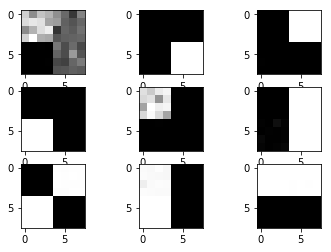

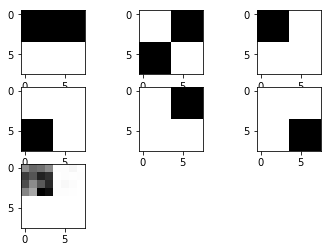

array([[  1.13495669e-04,   1.04655362e-06,   5.89926385e-05,
          5.50262994e-05],
       [  4.26676066e-04,   3.43515057e-06,   2.13814536e-04,
          9.99994576e-01],
       [  7.32045464e-08,   1.74608419e-03,   9.99576390e-01,
          5.85864647e-04],
       [  1.17548516e-04,   9.99049366e-01,   4.38072573e-04,
          1.62414779e-06],
       [  8.00315976e-01,   1.20456575e-03,   7.42885618e-07,
          4.09321292e-05],
       [  7.26282992e-11,   1.57637987e-02,   9.98739898e-01,
          9.99893963e-01],
       [  8.06802714e-09,   9.99999344e-01,   9.95123506e-01,
          4.29095380e-05],
       [  9.75010872e-01,   9.99216735e-01,   7.99384816e-06,
          1.11703434e-06],
       [  9.99815762e-01,   4.27262530e-05,   9.97535229e-01,
          5.33838902e-05],
       [  1.75270634e-06,   9.99421656e-01,   1.29265987e-04,
          9.99896824e-01],
       [  9.99965429e-01,   3.65827000e-05,   5.34133142e-06,
          9.99969065e-01],
       [  6.61351862e

In [72]:
import numpy
imgs = generated_images.reshape((-1, 8, 8))

for i, el in enumerate(imgs[0:9]):
    array2 = numpy.moveaxis(imgs[i], 0, -1)
    plt.subplot(3, 3, i + 1)
    plt.imshow(array2, cmap='gray')
plt.show()

for i, el in enumerate(imgs[9:]):
    array2 = numpy.moveaxis(imgs[i+9], 0, -1)
    plt.subplot(3, 3, i + 1)
    plt.imshow(array2, cmap='gray')
plt.show()
generated_codes

In [53]:
input_layer = tf.placeholder(tf.float32, shape=(None, 8, 8, 1))
conv1 = tf.layers.conv2d(
  inputs=input_layer,
  filters=32,
  kernel_size=[5, 5],
  activation=tf.nn.relu)

pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

pool2_flat = tf.reshape(pool1, [-1, 1 * 2 * 64])
      
labels = tf.placeholder(tf.float32, shape=(None, 1))
logits = tf.layers.dense(inputs=pool2_flat, units=1, activation=tf.tanh)

loss_recognized_image = tf.reduce_mean(tf.abs(logits - labels))
red_mean = tf.reduce_mean(loss_recognized_image)

des_2_trainer = tf.train.GradientDescentOptimizer(0.1).minimize(loss_recognized_image)

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    for i in range(0, len(image_reshaped)):
        sess.run([red_mean, des_2_trainer], feed_dict={input_layer: [image_reshaped[i]], labels: [image_labels[i]]})